# Prediction of time-resolved ISC from face features

*asortubay, 06/2024*

Time resolved ISC prediction from face features. The goal is to predict the ISC of a subject from 10 seconds' worth of face data. The face features are extracted from the video of the subject. 

Data can be made available upon request.


--------------------------

In [76]:
%matplotlib inline

import torch
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
import pickle
import importlib

#import custom modules
import dataset_utils, model_definitions_ISC, plot_utils

from dataset_utils import create_dataloader_ISC
from model_definitions_ISC import train_model, evaluate_model, compute_predictions_and_metrics
from plot_utils import plot_epoch_losses, display_results

Check if we want to compute the results again:

In [77]:
reComputeResults = False
reTrainModels = False
computeTestResults = False
result_directory = '../../results/python/1s_step_selectedpars/'

### Baseline


#### Linear regression from face features


-we average over the time-dimension

Data loading:

In [78]:
metadata_path = '../../processed/timeISC/metadata_ISC_fs=4Hz_urs_1_windowsz=40_stepsz=4_selectedpars.csv'
metadata = pd.read_csv(metadata_path)
data_path = os.path.dirname(metadata_path)  # Get directory of the metadata file
train_loader, val_loader, test_loader, test_trainsubs_loader = create_dataloader_ISC(metadata, data_path, batch_size=512, num_workers=0,shuffle=True, pin_memory=True)
len(train_loader.dataset), len(val_loader.dataset), len(test_loader.dataset), len(test_trainsubs_loader.dataset)

(21978, 3567, 3567, 1486)

In [79]:
modelName = 'LinearRegressionBaseline'
result_path = os.path.join(result_directory, modelName +  '.pickle')
model_weights_path = os.path.join(result_directory, modelName + '_model_weights.pth')
validation_print_path = os.path.join(result_directory, 'val_results_' + modelName + '.png')
print(result_path)
print(model_weights_path)
print(validation_print_path)

../../results/python/1s_step_selectedpars/LinearRegressionBaseline.pickle
../../results/python/1s_step_selectedpars/LinearRegressionBaseline_model_weights.pth
../../results/python/1s_step_selectedpars/val_results_LinearRegressionBaseline.png


Train R^2: 0.1567
Validation R^2: 0.0864


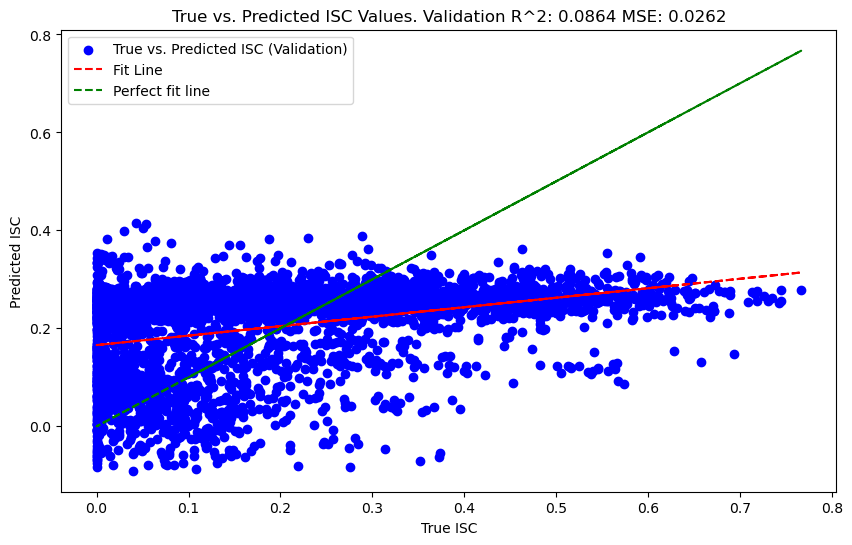

In [80]:

# Retrain model only if results dont exist or we want to retrain
if  reTrainModels or not os.path.exists(result_path):
    results = {}
    # Get the training data
    X_list = []
    y_list = []
    print('')
    for features, targets in train_loader:
        features_mean = features.mean(dim=2)
        ones_column = np.ones((features_mean.shape[0], 1))
        features_with_bias = np.concatenate((features_mean.numpy(), ones_column), axis=1)
        X_list.append(features_with_bias)
        y_list.append(targets.numpy()[:, np.newaxis])

    X_train = np.vstack(X_list)
    results['y_train'] = np.concatenate(y_list)

    # solve the least-squares problem
    results['w'], results['residuals'], results['rank'], results['s'] = np.linalg.lstsq(X_train, results['y_train'], rcond=None)
    
    #once we compute the model, compute results
    #Compute the MSE on the training set
    results['yest_train'] = X_train @ results['w']  
    results['MSE_train'] = mean_squared_error(results['y_train'], results['yest_train'])
    # compute R2: R2 = 1 - (np.sum((results['y_train'] - results['yest_train'])**2) / np.sum((results['y_train'] - np.mean(results['y_train']))**2))
    results['R2_train'] = r2_score(results['y_train'], results['yest_train'])
    
    # Compute the results on the validation set
    X_list = []
    y_list = []
    for features, targets in val_loader:
        features_mean = features.mean(dim=2)
        ones_column = np.ones((features_mean.shape[0], 1))
        features_with_bias = np.concatenate((features_mean.numpy(), ones_column), axis=1)
        X_list.append(features_with_bias)
        y_list.append(targets.numpy()[:, np.newaxis])
    X_val = np.vstack(X_list)
    results['y_val'] = np.concatenate(y_list)
    results['yest_val'] = X_val @ results['w']
    results['MSE_val'] = mean_squared_error(results['y_val'], results['yest_val'])
    results['R2_val'] = r2_score(results['y_val'], results['yest_val'])
    
    # Compute the results on the test set
    X_list = []
    y_list = []
    for features, targets in test_loader:
        features_mean = features.mean(dim=2)
        ones_column = np.ones((features_mean.shape[0], 1))
        features_with_bias = np.concatenate((features_mean.numpy(), ones_column), axis=1)
        X_list.append(features_with_bias)
        y_list.append(targets.numpy()[:, np.newaxis])
    X_test = np.vstack(X_list)
    results['y_test'] = np.concatenate(y_list)
    results['yest_test'] = X_test @ results['w']
    results['MSE_test'] = mean_squared_error(results['y_test'], results['yest_test'])
    results['R2_test'] = r2_score(results['y_test'], results['yest_test'])
    
    # Compute the results on the test (trainsubs) set
    X_list = []
    y_list = []
    for features, targets in test_trainsubs_loader:
        features_mean = features.mean(dim=2)
        ones_column = np.ones((features_mean.shape[0], 1))
        features_with_bias = np.concatenate((features_mean.numpy(), ones_column), axis=1)
        X_list.append(features_with_bias)
        y_list.append(targets.numpy()[:, np.newaxis])
    X_test_trainsubs = np.vstack(X_list)
    results['y_test_trainsubs'] = np.concatenate(y_list)
    results['yest_test_trainsubs'] = X_test_trainsubs @ results['w']
    results['MSE_test_trainsubs'] = mean_squared_error(results['y_test_trainsubs'], results['yest_test_trainsubs'])
    results['R2_test_trainsubs'] = r2_score(results['y_test_trainsubs'], results['yest_test_trainsubs'])
    
    # Serialize (save) the result dictionary to a file
    with open(result_path, 'wb') as handle:
        pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)
            
elif reComputeResults or reTrainModels:
    # load previously computed model
    with open(result_path, 'rb') as handle:
        results = pickle.load(handle)
    #once we load the model, compute results
    #Compute the MSE on the training set
    
    X_list = []
    y_list = []
    print('')
    for features, targets in train_loader:
        features_mean = features.mean(dim=2)
        ones_column = np.ones((features_mean.shape[0], 1))
        features_with_bias = np.concatenate((features_mean.numpy(), ones_column), axis=1)
        X_list.append(features_with_bias)
        y_list.append(targets.numpy()[:, np.newaxis])

    X_train = np.vstack(X_list)
    results['y_train'] = np.concatenate(y_list)
    results['yest_train'] = X_train @ results['w']  
    results['MSE_train'] = mean_squared_error(results['y_train'], results['yest_train'])
    # compute R2: R2 = 1 - (np.sum((results['y_train'] - results['yest_train'])**2) / np.sum((results['y_train'] - np.mean(results['y_train']))**2))
    results['R2_train'] = r2_score(results['y_train'], results['yest_train'])
    
    # Compute the results on the validation set
    X_list = []
    y_list = []
    for features, targets in val_loader:
        features_mean = features.mean(dim=2)
        ones_column = np.ones((features_mean.shape[0], 1))
        features_with_bias = np.concatenate((features_mean.numpy(), ones_column), axis=1)
        X_list.append(features_with_bias)
        y_list.append(targets.numpy()[:, np.newaxis])
    X_val = np.vstack(X_list)
    results['y_val'] = np.concatenate(y_list)
    results['yest_val'] = X_val @ results['w']
    results['MSE_val'] = mean_squared_error(results['y_val'], results['yest_val'])
    results['R2_val'] = r2_score(results['y_val'], results['yest_val'])
    
    # Compute the results on the test set
    X_list = []
    y_list = []
    for features, targets in test_loader:
        features_mean = features.mean(dim=2)
        ones_column = np.ones((features_mean.shape[0], 1))
        features_with_bias = np.concatenate((features_mean.numpy(), ones_column), axis=1)
        X_list.append(features_with_bias)
        y_list.append(targets.numpy()[:, np.newaxis])
    X_test = np.vstack(X_list)
    results['y_test'] = np.concatenate(y_list)
    results['yest_test'] = X_test @ results['w']
    results['MSE_test'] = mean_squared_error(results['y_test'], results['yest_test'])
    results['R2_test'] = r2_score(results['y_test'], results['yest_test'])
    
    # Compute the results on the test set
    X_list = []
    y_list = []
    for features, targets in test_trainsubs_loader:
        features_mean = features.mean(dim=2)
        ones_column = np.ones((features_mean.shape[0], 1))
        features_with_bias = np.concatenate((features_mean.numpy(), ones_column), axis=1)
        X_list.append(features_with_bias)
        y_list.append(targets.numpy()[:, np.newaxis])
    X_test_trainsubs = np.vstack(X_list)
    results['y_test_trainsubs'] = np.concatenate(y_list)
    results['yest_test_trainsubs'] = X_test_trainsubs @ results['w']
    results['MSE_test_trainsubs'] = mean_squared_error(results['y_test_trainsubs'], results['yest_test_trainsubs'])
    results['R2_test_trainsubs'] = r2_score(results['y_test_trainsubs'], results['yest_test_trainsubs'])
    
    # Serialize (save) the result dictionary to a file
    with open(result_path, 'wb') as handle:
        pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)
            
else:
    # load previously trained model and results
    with open(result_path, 'rb') as handle:
        results = pickle.load(handle)
 
# display the results
# display the results
fig = display_results(results,'val')
# save the latest plot to a file
fig.savefig(validation_print_path)
    


#### Random sampling from train distribution 

In [81]:
modelName = 'DistributionSamplingBaseline'
result_path = os.path.join(result_directory, modelName +  '.pickle')
model_weights_path = os.path.join(result_directory, modelName + '_model_weights.pth')
validation_print_path = os.path.join(result_directory, 'val_results_' + modelName + '.png')
print(result_path)
print(model_weights_path)
print(validation_print_path)

../../results/python/1s_step_selectedpars/DistributionSamplingBaseline.pickle
../../results/python/1s_step_selectedpars/DistributionSamplingBaseline_model_weights.pth
../../results/python/1s_step_selectedpars/val_results_DistributionSamplingBaseline.png


Train R^2: -0.9867
Validation R^2: -0.8814
Test R^2: -1.0158
Test (train subjects) R^2: -0.8405


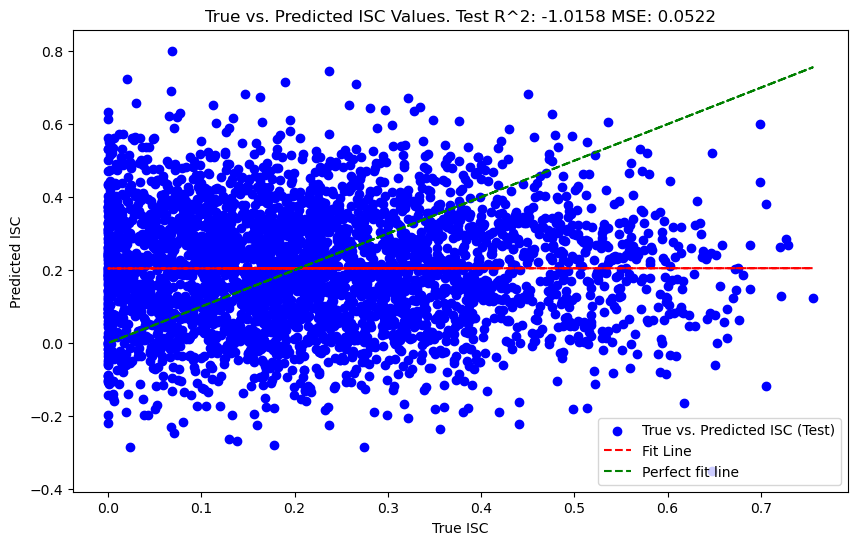

In [82]:
import numpy as np

if reTrainModels or not os.path.exists(result_path):
    results = {}
    y_list = []
    # Calculate Mean and Standard Deviation of target ISC values in the training set
    for features, targets in train_loader:
            y_list.append(targets.numpy()[:, np.newaxis])
    y_train = np.concatenate(y_list)  # Assuming y_list is already populated with training targets
    results['mean_isc'] = np.mean(y_train)
    results['std_isc'] = np.std(y_train)
    np.random.seed(42)
    # Function to generate random predictions based on the training set's distribution
    def generate_random_predictions(target_array, mean, std):
        random_predictions = np.random.normal(loc=mean, scale=std, size=target_array.shape)
        return random_predictions
    
    # Generate Random Predictions for Validation and Test Sets and compute metrics
    for loader, key in [(train_loader, 'train'),(val_loader, 'val'), (test_loader, 'test'), (test_trainsubs_loader, 'test_trainsubs')]:
        X_list = []
        y_list = []
        for features, targets in loader:
            y_list.append(targets.numpy()[:, np.newaxis])
        y_target = np.concatenate(y_list)
        y_random = generate_random_predictions(y_target, results['mean_isc'], results['std_isc'])
        results[f'y_{key}'] = y_target
        results[f'yest_{key}'] = y_random
        results[f'MSE_{key}'] = mean_squared_error(y_target, y_random)
        results[f'R2_{key}'] = r2_score(y_target, y_random)
    
    # Serialize (save) the baseline result dictionary to a file
    with open(result_path.replace('.pkl', '_baseline.pkl'), 'wb') as handle:
        pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)
            
elif reComputeResults or reTrainModels:
    # Load previously computed baseline model
    with open(result_path.replace('.pkl', '_baseline.pkl'), 'rb') as handle:
        results = pickle.load(handle)
    # No need to recompute random predictions as they are already saved
    
else:
    # Load previously computed baseline model
    with open(result_path.replace('.pkl', '_baseline.pkl'), 'rb') as handle:
        results = pickle.load(handle)

# Display the results
# Assuming display_results is a function that can take results and plot them
fig = display_results(results, 'test')
# Save the latest plot to a file
fig.savefig(validation_print_path)

#### Always predict mean from train distribution

In [83]:
modelName = 'MeanSamplingBaseline'
result_path = os.path.join(result_directory, modelName +  '.pickle')
model_weights_path = os.path.join(result_directory, modelName + '_model_weights.pth')
validation_print_path = os.path.join(result_directory, 'val_results_' + modelName + '.png')
print(result_path)
print(model_weights_path)
print(validation_print_path)

../../results/python/1s_step_selectedpars/MeanSamplingBaseline.pickle
../../results/python/1s_step_selectedpars/MeanSamplingBaseline_model_weights.pth
../../results/python/1s_step_selectedpars/val_results_MeanSamplingBaseline.png


Train R^2: -0.0000
Validation R^2: -0.0015
Test R^2: -0.0094
Test (train subjects) R^2: -0.0000


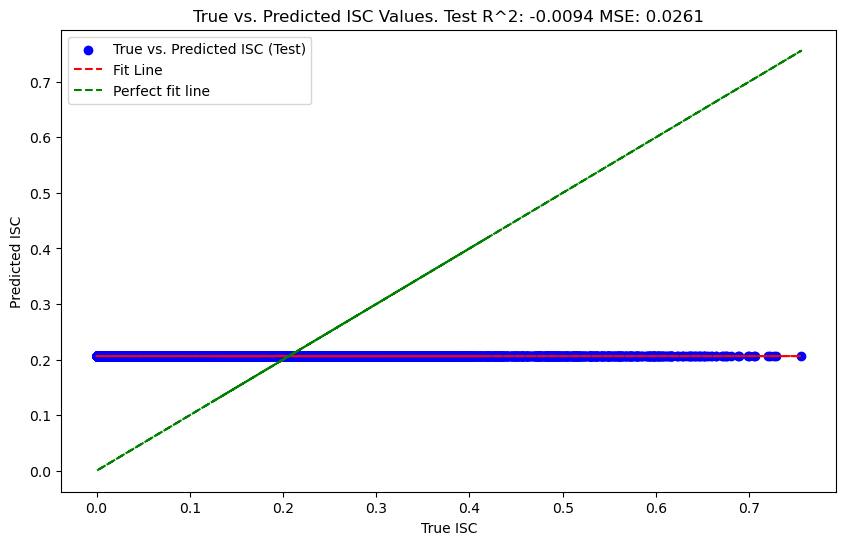

In [84]:
import numpy as np

if reTrainModels or not os.path.exists(result_path):
    results = {}
    y_list = []
    # Calculate Mean and Standard Deviation of target ISC values in the training set
    for features, targets in train_loader:
            y_list.append(targets.numpy()[:, np.newaxis])
    y_train = np.concatenate(y_list)  # Assuming y_list is already populated with training targets
    results['mean_isc'] = np.mean(y_train)
    np.random.seed(42)
    
    # Generate Random Predictions for Validation and Test Sets and compute metrics
    for loader, key in [(train_loader, 'train'),(val_loader, 'val'), (test_loader, 'test'), (test_trainsubs_loader, 'test_trainsubs')]:
        X_list = []
        y_list = []
        for features, targets in loader:
            y_list.append(targets.numpy()[:, np.newaxis])
        y_target = np.concatenate(y_list)
        y_random = np.ones(y_target.shape) * results['mean_isc']
        results[f'y_{key}'] = y_target
        results[f'yest_{key}'] = y_random
        results[f'MSE_{key}'] = mean_squared_error(y_target, y_random)
        results[f'R2_{key}'] = r2_score(y_target, y_random)
    
    # Serialize (save) the baseline result dictionary to a file
    with open(result_path.replace('.pkl', '_baseline.pkl'), 'wb') as handle:
        pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)
            
elif reComputeResults or reTrainModels:
    # Load previously computed baseline model
    with open(result_path.replace('.pkl', '_baseline.pkl'), 'rb') as handle:
        results = pickle.load(handle)
    # No need to recompute random predictions as they are already saved
    
else:
    # Load previously computed baseline model
    with open(result_path.replace('.pkl', '_baseline.pkl'), 'rb') as handle:
        results = pickle.load(handle)

# Display the results
# Assuming display_results is a function that can take results and plot them
fig = display_results(results, 'test')
# Save the latest plot to a file
fig.savefig(validation_print_path)

### Deep Learning Models

In [85]:
reComputeResults = False
reTrainModels = False
computeTestResults = False

In [86]:
batch_size = 128
n_epochs= 110

Data loading

In [87]:
metadata_path = '../../processed/timeISC/metadata_ISC_fs=4Hz_urs_1_windowsz=40_stepsz=4_selectedpars.csv'
metadata = pd.read_csv(metadata_path)
data_path = os.path.dirname(metadata_path)  # Get directory of the metadata file
train_loader, val_loader, test_loader, test_trainsubs_loader = create_dataloader_ISC(metadata, data_path, batch_size=batch_size, num_workers=4,shuffle=True, pin_memory=True, transform=None)
len(train_loader.dataset), len(val_loader.dataset), len(test_loader.dataset), len(test_trainsubs_loader.dataset)

(21978, 3567, 3567, 1486)

#### Multi-Layer Perceptron

In [88]:
from model_definitions_ISC import MLP
input_size = 64  # Number of features
input_length = 40  # Number of time steps
num_layers = 1
output_size = 1
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_shape = (input_size, input_length)
model = MLP(input_shape, nb_classes=output_size, normalize_features= True)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001, weight_decay=1e-5)
print(model)

MLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dense1): Linear(in_features=2560, out_features=500, bias=True)
  (dropout2): Dropout(p=0.2, inplace=False)
  (dense2): Linear(in_features=500, out_features=500, bias=True)
  (dropout3): Dropout(p=0.2, inplace=False)
  (dense3): Linear(in_features=500, out_features=500, bias=True)
  (dropout4): Dropout(p=0.3, inplace=False)
  (dense4): Linear(in_features=500, out_features=1, bias=True)
  (relu): ReLU()
)


In [89]:
modelName = 'MLP'
model_params_str = f"_input{input_size}_length{input_length}_output{output_size}_nepochs_{n_epochs}_bsize_{batch_size}"
result_path = os.path.join(result_directory, modelName + model_params_str + '.pickle')
model_weights_path = os.path.join(result_directory, modelName + model_params_str + '_model_weights.pth')
validation_print_path = os.path.join(result_directory, 'val_results_' + modelName + model_params_str + '.png')
model_structure_path = os.path.join(result_directory, modelName + model_params_str + '.txt')
with open(model_structure_path, 'w') as f:
    print(model, file=f)
print(result_path)
print(model_weights_path)
print(validation_print_path)

../../results/python/1s_step_selectedpars/MLP_input64_length40_output1_nepochs_110_bsize_128.pickle
../../results/python/1s_step_selectedpars/MLP_input64_length40_output1_nepochs_110_bsize_128_model_weights.pth
../../results/python/1s_step_selectedpars/val_results_MLP_input64_length40_output1_nepochs_110_bsize_128.png


Train R^2: 0.6490
Validation R^2: 0.3154


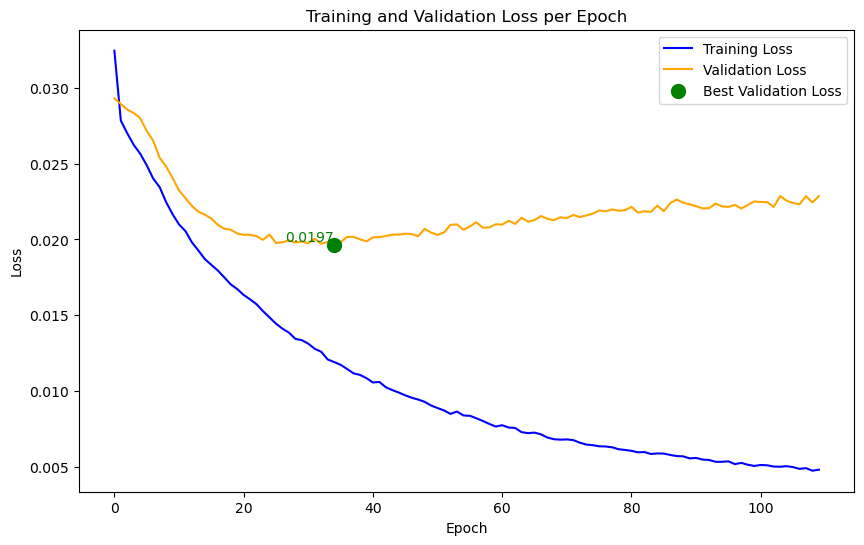

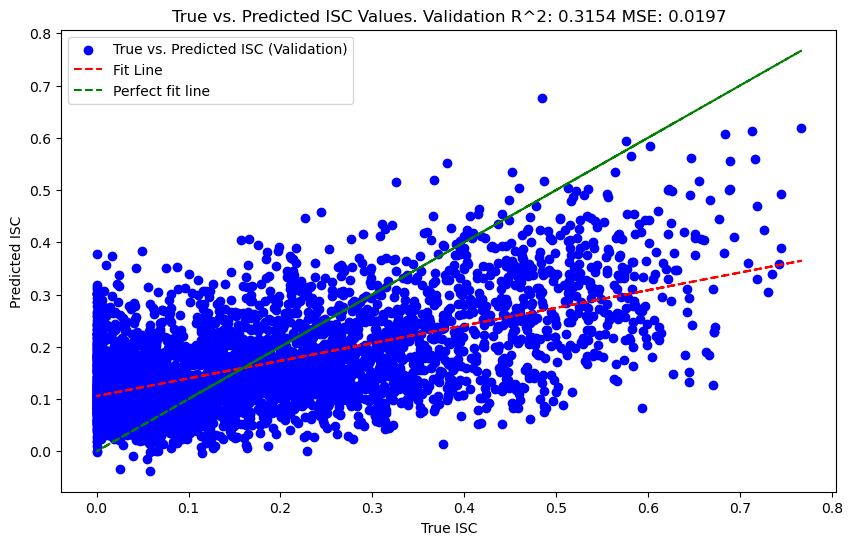

In [90]:
if os.path.exists(result_path):
    with open(result_path, 'rb') as handle:
        results = pickle.load(handle)
if  reTrainModels or not os.path.exists(model_weights_path):
    # retrain only if weights dont exist or we want to retrain
    # retrain model
    results['epoch_train_losses'], results['epoch_val_losses'], results['best_val_loss'] = train_model(train_loader, val_loader, model, criterion, optimizer, device, num_epochs=n_epochs, model_weights_path = model_weights_path)
        
if reComputeResults or not os.path.exists(result_path) or reTrainModels:
    # recompute results only if we want to recompute, or results dont exist, or we retrained models
    # load model weights and results
    model.load_state_dict(torch.load(model_weights_path, map_location=device))
    # recompute results
    model.eval()
    print('computing predictions and metrics for training set...')# Compute for training set
    results['y_train'], results['yest_train'], results['MSE_train'], results['R2_train'] = compute_predictions_and_metrics(train_loader,model, device)
    print('computing predictions and metrics for validation set...')# Compute for validation set
    results['y_val'], results['yest_val'], results['MSE_val'], results['R2_val'] = compute_predictions_and_metrics(val_loader,model, device)
    print('computing predictions and metrics for test set...')# Compute for test set 
    results['y_test'], results['yest_test'], results['MSE_test'], results['R2_test'] = compute_predictions_and_metrics(test_loader,model, device)
    print('computing predictions and metrics for test set (trainsubs)...')# Compute for test set (trainsubs)
    results['y_test_trainsubs'], results['yest_test_trainsubs'], results['MSE_test_trainsubs'], results['R2_test_trainsubs'], = compute_predictions_and_metrics(test_trainsubs_loader,model, device)
    # save results
    with open(result_path, 'wb') as handle:
        pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL) 

if os.path.exists(result_path) and os.path.exists(model_weights_path) and not reComputeResults and not reTrainModels:
    # if we didnt recompute anything and results exist, load them
    # load model
    model.load_state_dict(torch.load(model_weights_path, map_location=device))
    #load results 
    with open(result_path, 'rb') as handle:
        results = pickle.load(handle)

# Plot the epoch losses
plot_epoch_losses(results)
# display the results
fig = display_results(results,'val')
# save the latest plot to a file
fig.savefig(validation_print_path)

#### Simple LSTM


In [91]:
from model_definitions_ISC import LSTMModel
input_size = 64  # Number of features
input_length = 40  # Number of time steps
hidden_size = 256
num_layers = 1
output_size = 1
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = LSTMModel(input_size, hidden_size, num_layers, output_size, normalize_features= True)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001, weight_decay=1e-5)
print(model)

LSTMModel(
  (lstm): LSTM(64, 256, batch_first=True)
  (drop): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=256, out_features=1, bias=True)
)


In [92]:
modelName = 'LSTM'
model_params_str = f"_input{input_size}_length{input_length}_hidden{hidden_size}_layers{num_layers}_output{output_size}_nepochs_{n_epochs}_bsize_{batch_size}"
result_path = os.path.join(result_directory, modelName + model_params_str + '.pickle')
model_weights_path = os.path.join(result_directory, modelName + model_params_str + '_model_weights.pth')
validation_print_path = os.path.join(result_directory, 'val_results_' + modelName + model_params_str + '.png')
model_structure_path = os.path.join(result_directory, modelName + model_params_str + '.txt')
with open(model_structure_path, 'w') as f:
    print(model, file=f)
print(result_path)
print(model_weights_path)
print(validation_print_path)


../../results/python/1s_step_selectedpars/LSTM_input64_length40_hidden256_layers1_output1_nepochs_110_bsize_128.pickle
../../results/python/1s_step_selectedpars/LSTM_input64_length40_hidden256_layers1_output1_nepochs_110_bsize_128_model_weights.pth
../../results/python/1s_step_selectedpars/val_results_LSTM_input64_length40_hidden256_layers1_output1_nepochs_110_bsize_128.png


Train R^2: 0.5077
Validation R^2: 0.3795


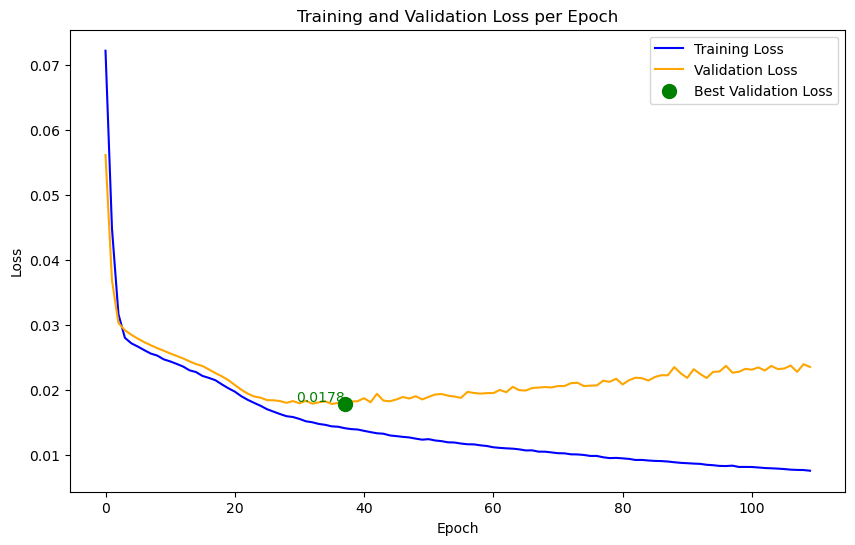

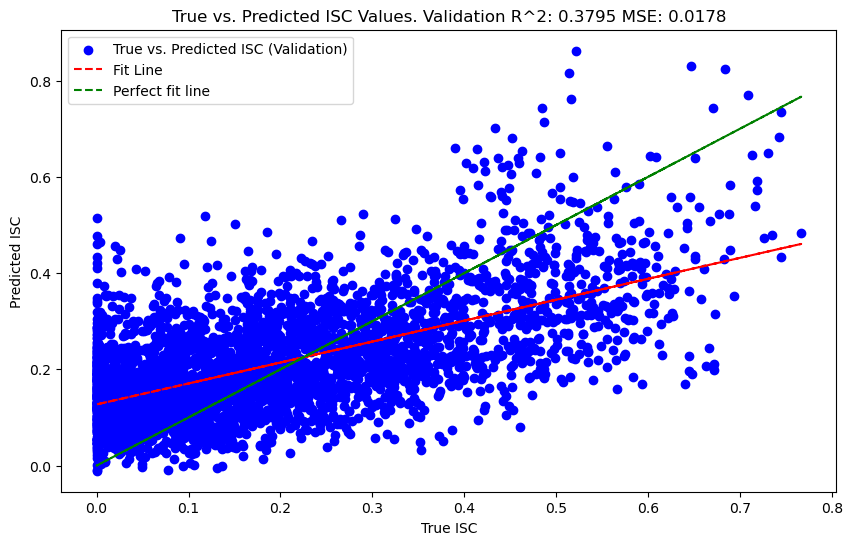

In [93]:

if os.path.exists(result_path):
    with open(result_path, 'rb') as handle:
        results = pickle.load(handle)
if  reTrainModels or not os.path.exists(model_weights_path):
    # retrain only if weights dont exist or we want to retrain
    # retrain model
    results['epoch_train_losses'], results['epoch_val_losses'], results['best_val_loss'] = train_model(train_loader, val_loader, model, criterion, optimizer, device, num_epochs=n_epochs, model_weights_path = model_weights_path)
        
if reComputeResults or not os.path.exists(result_path) or reTrainModels:
    # recompute results only if we want to recompute, or results dont exist, or we retrained models
    # load model weights and results
    model.load_state_dict(torch.load(model_weights_path, map_location=device))
    # recompute results
    model.eval()
    print('computing predictions and metrics for training set...')# Compute for training set
    results['y_train'], results['yest_train'], results['MSE_train'], results['R2_train'] = compute_predictions_and_metrics(train_loader,model, device)
    print('computing predictions and metrics for validation set...')# Compute for validation set
    results['y_val'], results['yest_val'], results['MSE_val'], results['R2_val'] = compute_predictions_and_metrics(val_loader,model, device)
    print('computing predictions and metrics for test set...')# Compute for test set 
    results['y_test'], results['yest_test'], results['MSE_test'], results['R2_test'] = compute_predictions_and_metrics(test_loader,model, device)
    print('computing predictions and metrics for test set (trainsubs)...')# Compute for test set (trainsubs)
    results['y_test_trainsubs'], results['yest_test_trainsubs'], results['MSE_test_trainsubs'], results['R2_test_trainsubs'], = compute_predictions_and_metrics(test_trainsubs_loader,model, device)
    # save results
    with open(result_path, 'wb') as handle:
        pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL) 

if os.path.exists(result_path) and os.path.exists(model_weights_path) and not reComputeResults and not reTrainModels:
    # if we didnt recompute anything and results exist, load them
    # load model
    model.load_state_dict(torch.load(model_weights_path, map_location=device))
    #load results
    with open(result_path, 'rb') as handle:
        results = pickle.load(handle)

# Plot the epoch losses
plot_epoch_losses(results)
# display the results
fig = display_results(results,'val')
# save the latest plot to a file
fig.savefig(validation_print_path)

In [94]:
reTrainModels = False

#### Simple Convolutional

In [95]:
# import model_definitions_ISC
from model_definitions_ISC import simpleConvolutional
input_channels = 64
seq_length = 40
output_size = 1
hidden_size = 256
num_layers = 2
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the model
model = simpleConvolutional(input_size = input_channels,output_size = output_size, normalize_features=False).to(device)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
print(model)
summary(model, (64, 40))

simpleConvolutional(
  (conv1): Conv1d(64, 64, kernel_size=(5,), stride=(1,), padding=(3,))
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1d(64, 128, kernel_size=(5,), stride=(1,), padding=(3,))
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv1d(128, 256, kernel_size=(5,), stride=(1,), padding=(3,))
  (bn3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv1d(256, 256, kernel_size=(5,), stride=(1,), padding=(3,))
  (bn4): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=512, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
  (drop): Dropout(p=0.25, inplace=False)
)
----

In [96]:
modelName = 'simpleConvolutional'
model_params_str = f"_inchannels{input_channels}_output{output_size}_nepochs_{n_epochs}_bsize_{batch_size}"
result_path = os.path.join(result_directory, modelName + model_params_str + '.pickle')
model_weights_path = os.path.join(result_directory, modelName + model_params_str + '_model_weights.pth')
validation_print_path = os.path.join(result_directory, 'val_results_' + modelName + model_params_str + '.png')
model_structure_path = os.path.join(result_directory, modelName + model_params_str + '.txt')
with open(model_structure_path, 'w') as f:
    print(model, file=f)
print(result_path)
print(model_weights_path)
print(validation_print_path)

../../results/python/1s_step_selectedpars/simpleConvolutional_inchannels64_output1_nepochs_110_bsize_128.pickle
../../results/python/1s_step_selectedpars/simpleConvolutional_inchannels64_output1_nepochs_110_bsize_128_model_weights.pth
../../results/python/1s_step_selectedpars/val_results_simpleConvolutional_inchannels64_output1_nepochs_110_bsize_128.png


Train R^2: 0.4148
Validation R^2: 0.3369


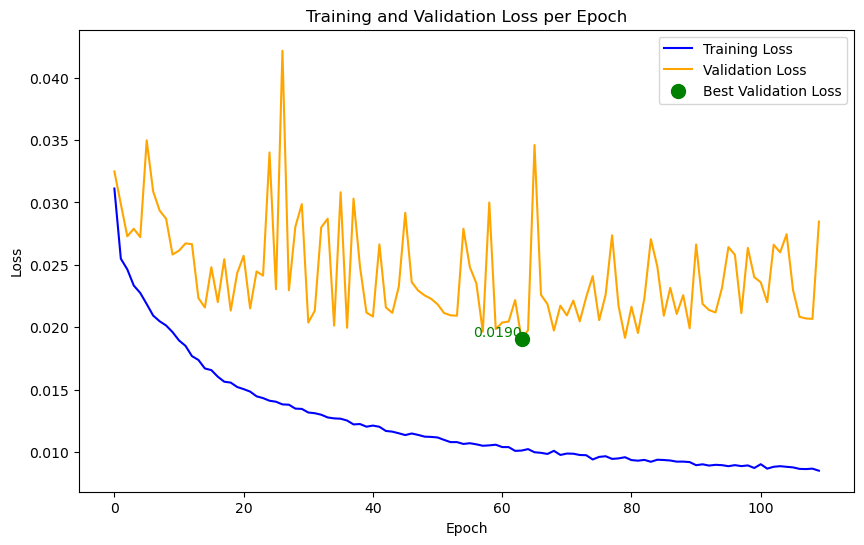

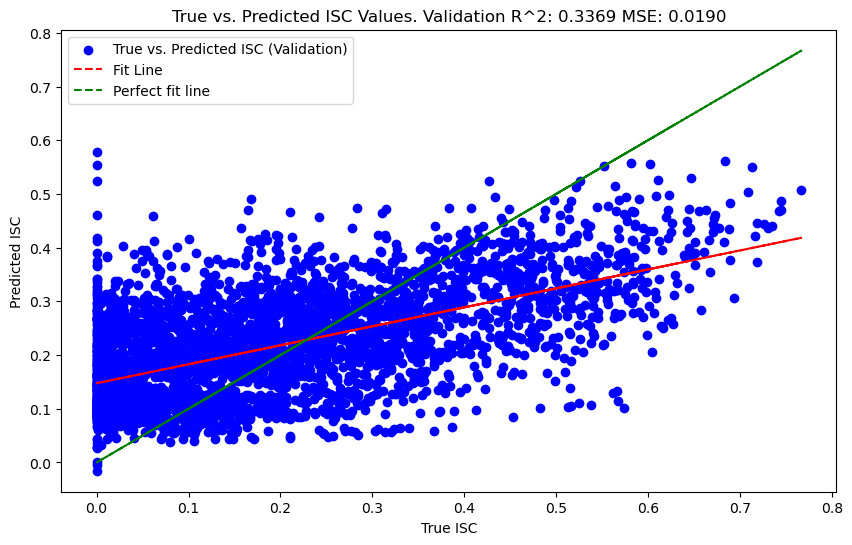

In [97]:
if os.path.exists(result_path):
    with open(result_path, 'rb') as handle:
        results = pickle.load(handle)
if  reTrainModels or not os.path.exists(model_weights_path):
    # retrain only if weights dont exist or we want to retrain
    # retrain model
    results['epoch_train_losses'], results['epoch_val_losses'], results['best_val_loss'] = train_model(train_loader, val_loader, model, criterion, optimizer, device, num_epochs=n_epochs, model_weights_path = model_weights_path)
        
if reComputeResults or not os.path.exists(result_path) or reTrainModels:
    # recompute results only if we want to recompute, or results dont exist, or we retrained models
    # load model weights and results
    model.load_state_dict(torch.load(model_weights_path, map_location=device))
    # recompute results
    model.eval()
    print('computing predictions and metrics for training set...')# Compute for training set
    results['y_train'], results['yest_train'], results['MSE_train'], results['R2_train'] = compute_predictions_and_metrics(train_loader,model, device)
    print('computing predictions and metrics for validation set...')# Compute for validation set
    results['y_val'], results['yest_val'], results['MSE_val'], results['R2_val'] = compute_predictions_and_metrics(val_loader,model, device)
    print('computing predictions and metrics for test set...')# Compute for test set 
    results['y_test'], results['yest_test'], results['MSE_test'], results['R2_test'] = compute_predictions_and_metrics(test_loader,model, device)
    print('computing predictions and metrics for test set (trainsubs)...')# Compute for test set (trainsubs)
    results['y_test_trainsubs'], results['yest_test_trainsubs'], results['MSE_test_trainsubs'], results['R2_test_trainsubs'], = compute_predictions_and_metrics(test_trainsubs_loader,model, device)
    # save results
    with open(result_path, 'wb') as handle:
        pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL) 

if os.path.exists(result_path) and os.path.exists(model_weights_path) and not reComputeResults and not reTrainModels:
    # if we didnt recompute anything and results exist, load them
    # load model
    model.load_state_dict(torch.load(model_weights_path, map_location=device))
    #load results
    with open(result_path, 'rb') as handle:
        results = pickle.load(handle)

# Plot the epoch losses
plot_epoch_losses(results)
# display the results
fig = display_results(results,'val')
# save the latest plot to a file
fig.savefig(validation_print_path)

In [98]:
reTrainModels = False

#### Depthwise - Convolutional LSTM

In [99]:
# import model_definitions_ISC
from model_definitions_ISC import DepthwiseConvLSTM
input_channels = 64
seq_length = 40
output_size = 1
hidden_size = 256
num_layers = 2
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the model
model = DepthwiseConvLSTM(num_features = input_channels, seq_length = seq_length, hidden_size = hidden_size, num_layers = num_layers, output_size = output_size, normalize_features=True)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001, weight_decay=1e-5)
print(model)



DepthwiseConvLSTM(
  (depthwise_conv): Conv1d(64, 128, kernel_size=(5,), stride=(1,), padding=same, groups=64)
  (pointwise_conv): Conv1d(128, 128, kernel_size=(1,), stride=(1,))
  (bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lstm): LSTM(128, 256, num_layers=2, batch_first=True, dropout=0.25)
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
  (drop): Dropout(p=0.25, inplace=False)
  (relu): ReLU()
)


In [100]:
modelName = 'DepthwiseConvLSTM'
model_params_str = f"_inchannels{input_channels}_output{output_size}_hiddensize_{hidden_size}_numlayers_{num_layers}_nepochs_{n_epochs}_bsize_{batch_size}"
result_path = os.path.join(result_directory, modelName + model_params_str + '.pickle')
model_weights_path = os.path.join(result_directory, modelName + model_params_str + '_model_weights.pth')
validation_print_path = os.path.join(result_directory, 'val_results_' + modelName + model_params_str + '.png')
model_structure_path = os.path.join(result_directory, modelName + model_params_str + '.txt')
with open(model_structure_path, 'w') as f:
    print(model, file=f)
print(result_path)
print(model_weights_path)
print(validation_print_path)

../../results/python/1s_step_selectedpars/DepthwiseConvLSTM_inchannels64_output1_hiddensize_256_numlayers_2_nepochs_110_bsize_128.pickle
../../results/python/1s_step_selectedpars/DepthwiseConvLSTM_inchannels64_output1_hiddensize_256_numlayers_2_nepochs_110_bsize_128_model_weights.pth
../../results/python/1s_step_selectedpars/val_results_DepthwiseConvLSTM_inchannels64_output1_hiddensize_256_numlayers_2_nepochs_110_bsize_128.png


Train R^2: 0.3971
Validation R^2: 0.3227


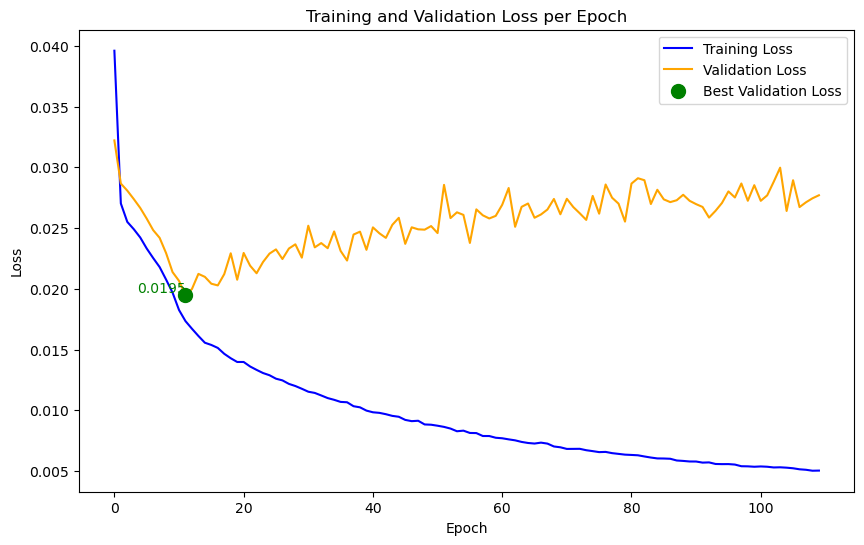

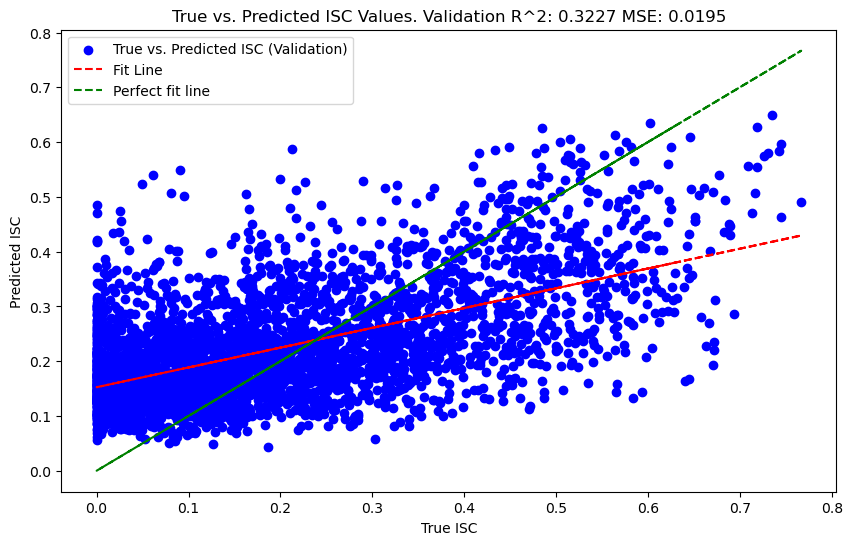

In [101]:
if os.path.exists(result_path):
    with open(result_path, 'rb') as handle:
        results = pickle.load(handle)
if  reTrainModels or not os.path.exists(model_weights_path):
    # retrain only if weights dont exist or we want to retrain
    # retrain model
    results['epoch_train_losses'], results['epoch_val_losses'], results['best_val_loss'] = train_model(train_loader, val_loader, model, criterion, optimizer, device, num_epochs=n_epochs, model_weights_path = model_weights_path)
        
if reComputeResults or not os.path.exists(result_path) or reTrainModels:
    # recompute results only if we want to recompute, or results dont exist, or we retrained models
    # load model weights and results
    model.load_state_dict(torch.load(model_weights_path, map_location=device))
    # recompute results
    model.eval()
    print('computing predictions and metrics for training set...')# Compute for training set
    results['y_train'], results['yest_train'], results['MSE_train'], results['R2_train'] = compute_predictions_and_metrics(train_loader,model, device)
    print('computing predictions and metrics for validation set...')# Compute for validation set
    results['y_val'], results['yest_val'], results['MSE_val'], results['R2_val'] = compute_predictions_and_metrics(val_loader,model, device)
    print('computing predictions and metrics for test set...')# Compute for test set 
    results['y_test'], results['yest_test'], results['MSE_test'], results['R2_test'] = compute_predictions_and_metrics(test_loader,model, device)
    print('computing predictions and metrics for test set (trainsubs)...')# Compute for test set (trainsubs)
    results['y_test_trainsubs'], results['yest_test_trainsubs'], results['MSE_test_trainsubs'], results['R2_test_trainsubs'], = compute_predictions_and_metrics(test_trainsubs_loader,model, device)
    # save results
    with open(result_path, 'wb') as handle:
        pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL) 

if os.path.exists(result_path) and os.path.exists(model_weights_path) and not reComputeResults and not reTrainModels:
    # if we didnt recompute anything and results exist, load them
    # load model
    model.load_state_dict(torch.load(model_weights_path, map_location=device))
    #load results
    with open(result_path, 'rb') as handle:
        results = pickle.load(handle)

# Plot the epoch losses
plot_epoch_losses(results)
# display the results
fig = display_results(results,'val')
# save the latest plot to a file
fig.savefig(validation_print_path)

#### One-dimensional CNN


In [102]:
# import model_definitions_ISC
from model_definitions_ISC import OneDimCNNModel
input_channels = 64
output_size = 1
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the model
model = OneDimCNNModel(input_channels, output_size, normalize_features=True).to(device)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)
print(model)
# summary(model, (64, 40))

OneDimCNNModel(
  (conv1): Conv1d(64, 64, kernel_size=(1,), stride=(1,), padding=same)
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1d(64, 128, kernel_size=(1,), stride=(1,), padding=same)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1280, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.25, inplace=False)
  (pool): AdaptiveAvgPool1d(output_size=10)
)


In [103]:
modelName = 'OneDimCNN'
model_params_str = f"_inchannels{input_channels}_output{output_size}_nepochs_{n_epochs}_bsize_{batch_size}"
result_path = os.path.join(result_directory, modelName + model_params_str + '.pickle')
model_weights_path = os.path.join(result_directory, modelName + model_params_str + '_model_weights.pth')
validation_print_path = os.path.join(result_directory, 'val_results_' + modelName + model_params_str + '.png')
model_structure_path = os.path.join(result_directory, modelName + model_params_str + '.txt')
with open(model_structure_path, 'w') as f:
    print(model, file=f)
print(result_path)
print(model_weights_path)
print(validation_print_path)


../../results/python/1s_step_selectedpars/OneDimCNN_inchannels64_output1_nepochs_110_bsize_128.pickle
../../results/python/1s_step_selectedpars/OneDimCNN_inchannels64_output1_nepochs_110_bsize_128_model_weights.pth
../../results/python/1s_step_selectedpars/val_results_OneDimCNN_inchannels64_output1_nepochs_110_bsize_128.png


Train R^2: 0.6182
Validation R^2: 0.4012


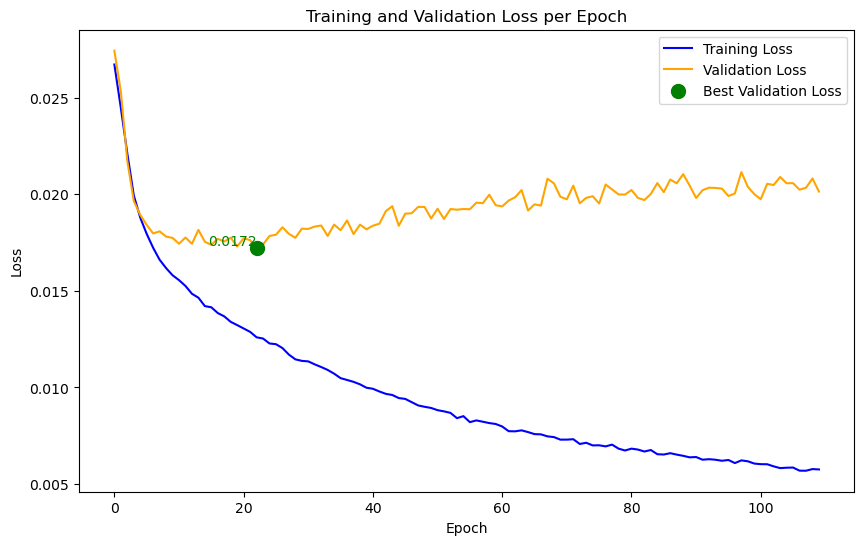

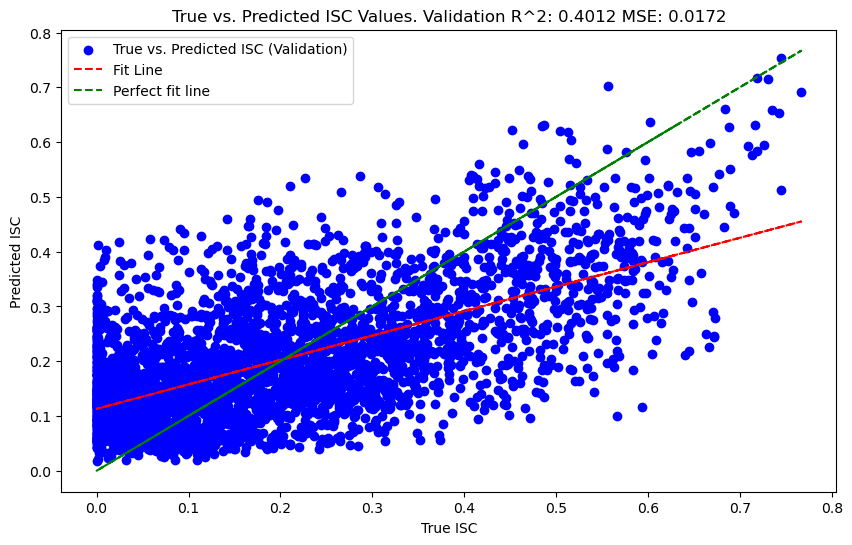

In [104]:

if os.path.exists(result_path):
    with open(result_path, 'rb') as handle:
        results = pickle.load(handle)
if  reTrainModels or not os.path.exists(model_weights_path):
    # retrain only if weights dont exist or we want to retrain
    # retrain model
    results['epoch_train_losses'], results['epoch_val_losses'], results['best_val_loss'] = train_model(train_loader, val_loader, model, criterion, optimizer, device, num_epochs=n_epochs, model_weights_path = model_weights_path)

if reComputeResults or not os.path.exists(result_path) or reTrainModels:
    # recompute results only if we want to recompute, or results dont exist, or we retrained models
    # load model weights and results
    model.load_state_dict(torch.load(model_weights_path, map_location=device))
    # recompute results
    model.eval()
    print('computing predictions and metrics for training set...')# Compute for training set
    results['y_train'], results['yest_train'], results['MSE_train'], results['R2_train'] = compute_predictions_and_metrics(train_loader,model, device)
    print('computing predictions and metrics for validation set...')# Compute for validation set
    results['y_val'], results['yest_val'], results['MSE_val'], results['R2_val'] = compute_predictions_and_metrics(val_loader,model, device)
    print('computing predictions and metrics for test set...')# Compute for test set 
    results['y_test'], results['yest_test'], results['MSE_test'], results['R2_test'] = compute_predictions_and_metrics(test_loader,model, device)
    print('computing predictions and metrics for test set (trainsubs)...')# Compute for test set (trainsubs)
    results['y_test_trainsubs'], results['yest_test_trainsubs'], results['MSE_test_trainsubs'], results['R2_test_trainsubs'], = compute_predictions_and_metrics(test_trainsubs_loader,model, device)
    # save results
    with open(result_path, 'wb') as handle:
        pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL) 

if os.path.exists(result_path) and os.path.exists(model_weights_path) and not reComputeResults and not reTrainModels:
    # if we didnt recompute anything and results exist, load them
    # load model
    model.load_state_dict(torch.load(model_weights_path, map_location=device))
    #load results
    with open(result_path, 'rb') as handle:
        results = pickle.load(handle)

# Plot the epoch losses
plot_epoch_losses(results)
# display the results
fig = display_results(results,'val')
# save the latest plot to a file
fig.savefig(validation_print_path)

#### CNN + Bidirectional GRU


In [105]:
from model_definitions_ISC import CNNGRUModel_bidirectional
input_size = 64  # Number of features
input_length = 40  # Number of time steps
hidden_size = 256
num_layers = 2
output_size = 1
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = CNNGRUModel_bidirectional(input_size, hidden_size, num_layers, output_size, bidirectional = True, normalize_features= True)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001, weight_decay=1e-5)
print(model)
# summary(model, (64, 40))

CNNGRUModel_bidirectional(
  (conv1): Conv1d(64, 128, kernel_size=(1,), stride=(1,), padding=same)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(128, 256, kernel_size=(1,), stride=(1,), padding=same)
  (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropCNN): Dropout(p=0.25, inplace=False)
  (gru): GRU(256, 256, num_layers=2, batch_first=True, dropout=0.25, bidirectional=True)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (drop): Dropout(p=0.25, inplace=False)
)


In [106]:
modelName = 'CNNGRUModel_bidirectional'
model_params_str = f"_input{input_size}_length{input_length}_hidden{hidden_size}_layers{num_layers}_output{output_size}_nepochs_{n_epochs}_bsize_{batch_size}"
result_path = os.path.join(result_directory, modelName + model_params_str + '.pickle')
model_weights_path = os.path.join(result_directory, modelName + model_params_str + '_model_weights.pth')
validation_print_path = os.path.join(result_directory, 'val_results_' + modelName + model_params_str + '.png')
model_structure_path = os.path.join(result_directory, modelName + model_params_str + '.txt')
with open(model_structure_path, 'w') as f:
    print(model, file=f)
print(result_path)
print(model_weights_path)
print(validation_print_path)

../../results/python/1s_step_selectedpars/CNNGRUModel_bidirectional_input64_length40_hidden256_layers2_output1_nepochs_110_bsize_128.pickle
../../results/python/1s_step_selectedpars/CNNGRUModel_bidirectional_input64_length40_hidden256_layers2_output1_nepochs_110_bsize_128_model_weights.pth
../../results/python/1s_step_selectedpars/val_results_CNNGRUModel_bidirectional_input64_length40_hidden256_layers2_output1_nepochs_110_bsize_128.png


Train R^2: 0.5876
Validation R^2: 0.3915


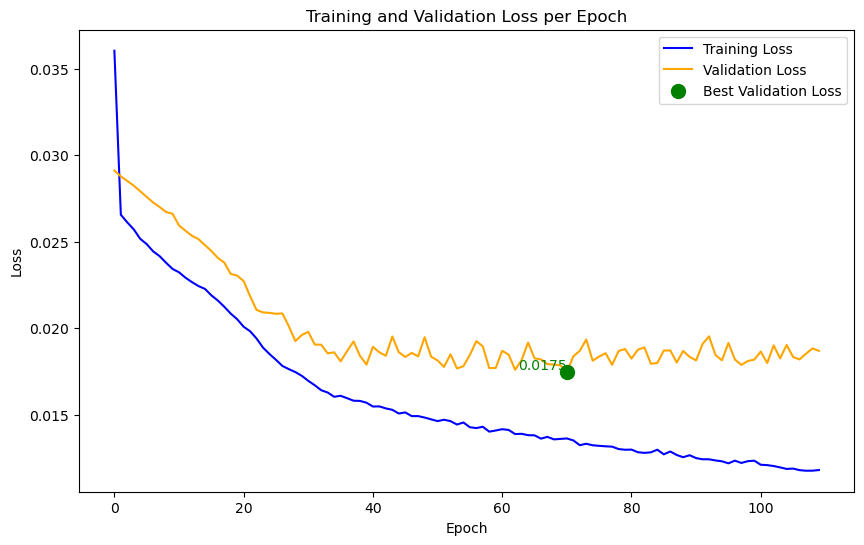

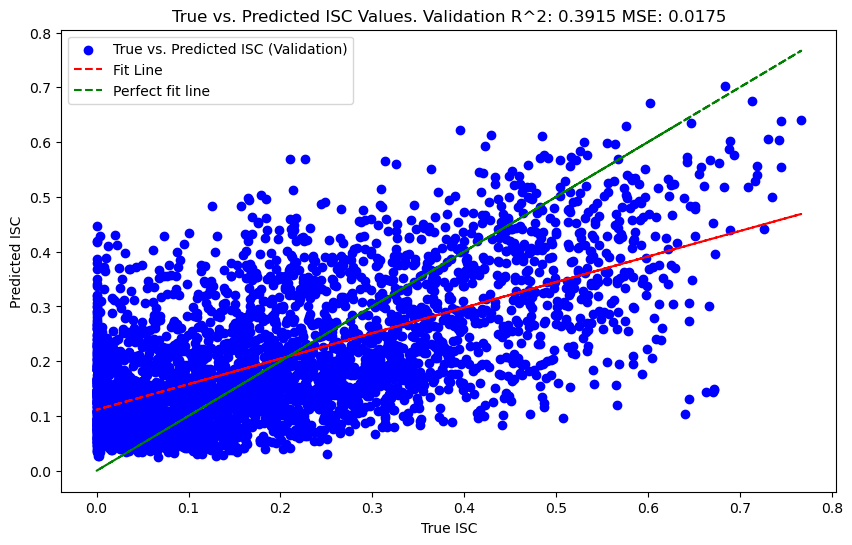

In [107]:

if os.path.exists(result_path):
    with open(result_path, 'rb') as handle:
        results = pickle.load(handle)
if  reTrainModels or not os.path.exists(model_weights_path):
    # retrain only if weights dont exist or we want to retrain
    # retrain model
    results['epoch_train_losses'], results['epoch_val_losses'], results['best_val_loss'] = train_model(train_loader, val_loader, model, criterion, optimizer, device, num_epochs=n_epochs, model_weights_path = model_weights_path)

        
if reComputeResults or not os.path.exists(result_path) or reTrainModels:
    # recompute results only if we want to recompute, or results dont exist, or we retrained models
    # load model weights and results
    model.load_state_dict(torch.load(model_weights_path, map_location=device))
    # recompute results
    model.eval()
    print('computing predictions and metrics for training set...')# Compute for training set
    results['y_train'], results['yest_train'], results['MSE_train'], results['R2_train'] = compute_predictions_and_metrics(train_loader,model, device)
    print('computing predictions and metrics for validation set...')# Compute for validation set
    results['y_val'], results['yest_val'], results['MSE_val'], results['R2_val'] = compute_predictions_and_metrics(val_loader,model, device)
    print('computing predictions and metrics for test set...')# Compute for test set 
    results['y_test'], results['yest_test'], results['MSE_test'], results['R2_test'] = compute_predictions_and_metrics(test_loader,model, device)
    print('computing predictions and metrics for test set (trainsubs)...')# Compute for test set (trainsubs)
    results['y_test_trainsubs'], results['yest_test_trainsubs'], results['MSE_test_trainsubs'], results['R2_test_trainsubs'], = compute_predictions_and_metrics(test_trainsubs_loader,model, device)
    # save results
    with open(result_path, 'wb') as handle:
        pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL) 

if os.path.exists(result_path) and os.path.exists(model_weights_path) and not reComputeResults and not reTrainModels:
    # if we didnt recompute anything and results exist, load them
    # load model
    model.load_state_dict(torch.load(model_weights_path, map_location=device))
    #load results
    with open(result_path, 'rb') as handle:
        results = pickle.load(handle)

# Plot the epoch losses
plot_epoch_losses(results)
# display the results
fig = display_results(results,'val')
# save the latest plot to a file
fig.savefig(validation_print_path)

#### Bidirectional LSTM


In [108]:
from model_definitions_ISC import BidirectionalLSTMModel
input_size = 64  # Number of features
input_length = 40  # Number of time steps
hidden_size = 256
num_layers = 2
output_size = 1
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = BidirectionalLSTMModel(input_size, hidden_size, num_layers, output_size, bidirectional = True, normalize_features= True)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001, weight_decay=1e-5)
print(model)


BidirectionalLSTMModel(
  (lstm): LSTM(64, 256, num_layers=2, batch_first=True, dropout=0.25, bidirectional=True)
  (drop): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=512, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU(inplace=True)
)


In [109]:
modelName = 'BidirectionalLSTM'
model_params_str = f"_input{input_size}_length{input_length}_hidden{hidden_size}_layers{num_layers}_output{output_size}_nepochs_{n_epochs}_bsize_{batch_size}"
result_path = os.path.join(result_directory, modelName + model_params_str + '.pickle')
model_weights_path = os.path.join(result_directory, modelName + model_params_str + '_model_weights.pth')
validation_print_path = os.path.join(result_directory, 'val_results_' + modelName + model_params_str + '.png')
model_structure_path = os.path.join(result_directory, modelName + model_params_str + '.txt')
with open(model_structure_path, 'w') as f:
    print(model, file=f)
print(result_path)
print(model_weights_path)
print(validation_print_path)

../../results/python/1s_step_selectedpars/BidirectionalLSTM_input64_length40_hidden256_layers2_output1_nepochs_110_bsize_128.pickle
../../results/python/1s_step_selectedpars/BidirectionalLSTM_input64_length40_hidden256_layers2_output1_nepochs_110_bsize_128_model_weights.pth
../../results/python/1s_step_selectedpars/val_results_BidirectionalLSTM_input64_length40_hidden256_layers2_output1_nepochs_110_bsize_128.png


Train R^2: 0.5040
Validation R^2: 0.3885


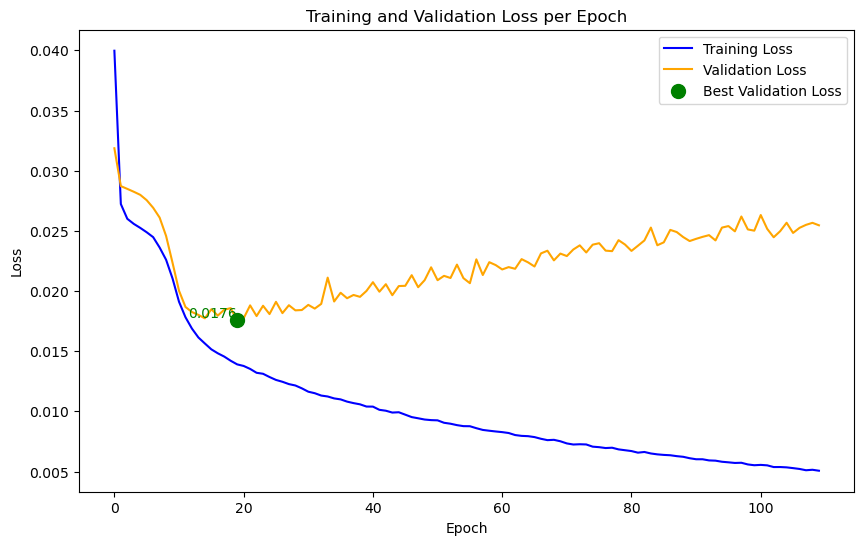

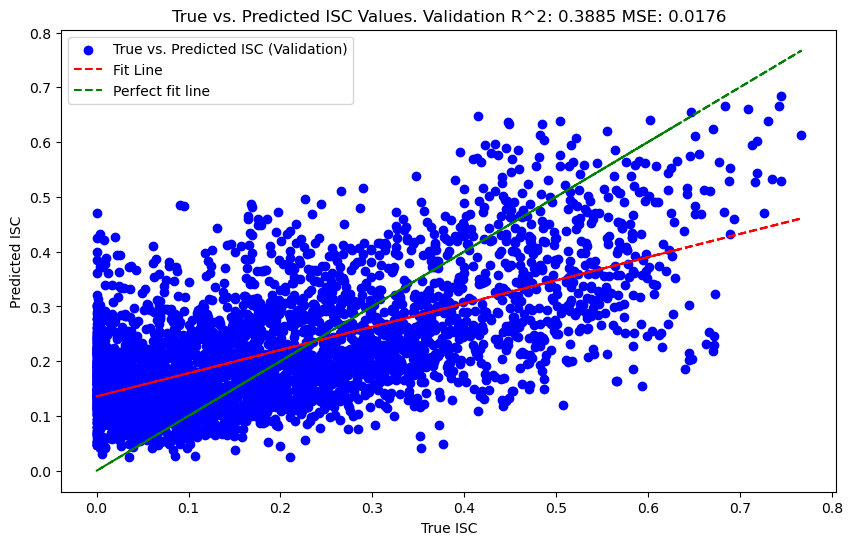

In [110]:

if os.path.exists(result_path):
    with open(result_path, 'rb') as handle:
        results = pickle.load(handle)
if  reTrainModels or not os.path.exists(model_weights_path):
    # retrain only if weights dont exist or we want to retrain
    # retrain model
    results['epoch_train_losses'], results['epoch_val_losses'], results['best_val_loss'] = train_model(train_loader, val_loader, model, criterion, optimizer, device, num_epochs=n_epochs, model_weights_path = model_weights_path)

        
if reComputeResults or not os.path.exists(result_path) or reTrainModels:
    # recompute results only if we want to recompute, or results dont exist, or we retrained models
    # load model weights and results
    model.load_state_dict(torch.load(model_weights_path, map_location=device))
    # recompute results
    model.eval()
    print('computing predictions and metrics for training set...')# Compute for training set
    results['y_train'], results['yest_train'], results['MSE_train'], results['R2_train'] = compute_predictions_and_metrics(train_loader,model, device)
    print('computing predictions and metrics for validation set...')# Compute for validation set
    results['y_val'], results['yest_val'], results['MSE_val'], results['R2_val'] = compute_predictions_and_metrics(val_loader,model, device)
    print('computing predictions and metrics for test set...')# Compute for test set 
    results['y_test'], results['yest_test'], results['MSE_test'], results['R2_test'] = compute_predictions_and_metrics(test_loader,model, device)
    print('computing predictions and metrics for test set (trainsubs)...')# Compute for test set (trainsubs)
    results['y_test_trainsubs'], results['yest_test_trainsubs'], results['MSE_test_trainsubs'], results['R2_test_trainsubs'], = compute_predictions_and_metrics(test_trainsubs_loader,model, device)
    # save results
    with open(result_path, 'wb') as handle:
        pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL) 

if os.path.exists(result_path) and os.path.exists(model_weights_path) and not reComputeResults and not reTrainModels:
    # if we didnt recompute anything and results exist, load them
    # load model
    model.load_state_dict(torch.load(model_weights_path, map_location=device))
    #load results
    with open(result_path, 'rb') as handle:
        results = pickle.load(handle)

# Plot the epoch losses
plot_epoch_losses(results)
# display the results
fig = display_results(results,'val')
# save the latest plot to a file
fig.savefig(validation_print_path)

#### CNN + LSTM


In [111]:
from model_definitions_ISC import CNNLSTMModel

# Assuming the CNNLSTMModel expects the number of input channels, sequence length, hidden size, number of LSTM layers, and output size
input_channels = 64   
seq_length = 40    
hidden_size = 128  # Hidden size for the LSTM layer
num_layers = 2  # Number of LSTM layers
output_size = 1  # Output size
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the model
model = CNNLSTMModel(input_channels, seq_length, hidden_size, num_layers, output_size, normalize_features= True).to(device)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)
# summary(model, input_size = (input_size, input_length))
print(model)

CNNLSTMModel(
  (conv1): Conv1d(64, 128, kernel_size=(1,), stride=(1,), padding=same)
  (conv2): Conv1d(128, 256, kernel_size=(1,), stride=(1,), padding=same)
  (conv3): Conv1d(256, 512, kernel_size=(1,), stride=(1,), padding=same)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lstm): LSTM(512, 128, num_layers=2, batch_first=True, dropout=0.25)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=128, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)


In [112]:
modelName = 'CNNLSTM'
model_params_str = f"_inchannels{input_channels}_seqlength{seq_length}_hidden{hidden_size}_layers{num_layers}_output{output_size}_nepochs_{n_epochs}_bsize_{batch_size}"
result_path = os.path.join(result_directory, modelName + model_params_str + '.pickle')
model_weights_path = os.path.join(result_directory, modelName + model_params_str + '_model_weights.pth')
validation_print_path = os.path.join(result_directory, 'val_results_' + modelName + model_params_str + '.png')
model_structure_path = os.path.join(result_directory, modelName + model_params_str + '.txt')
with open(model_structure_path, 'w') as f:
    print(model, file=f)
print(result_path)
print(model_weights_path)
print(validation_print_path)

../../results/python/1s_step_selectedpars/CNNLSTM_inchannels64_seqlength40_hidden128_layers2_output1_nepochs_110_bsize_128.pickle
../../results/python/1s_step_selectedpars/CNNLSTM_inchannels64_seqlength40_hidden128_layers2_output1_nepochs_110_bsize_128_model_weights.pth
../../results/python/1s_step_selectedpars/val_results_CNNLSTM_inchannels64_seqlength40_hidden128_layers2_output1_nepochs_110_bsize_128.png


Train R^2: 0.9763
Validation R^2: 0.3335


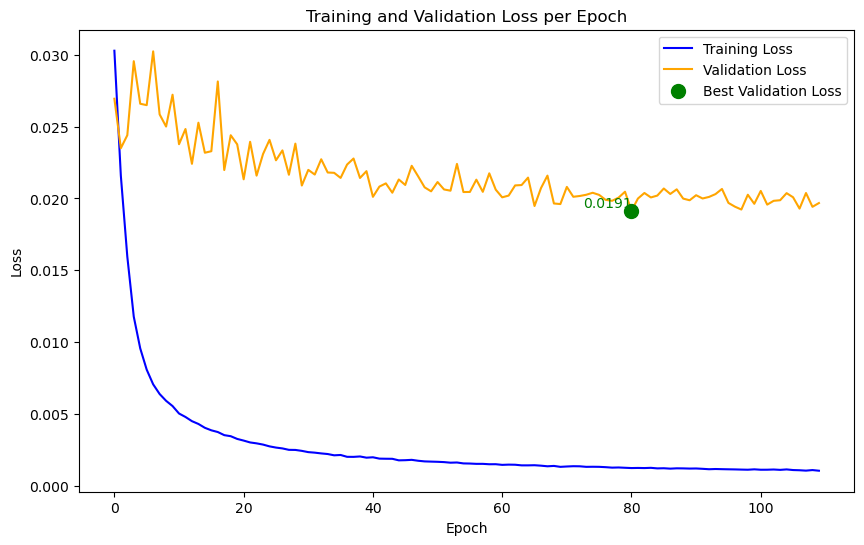

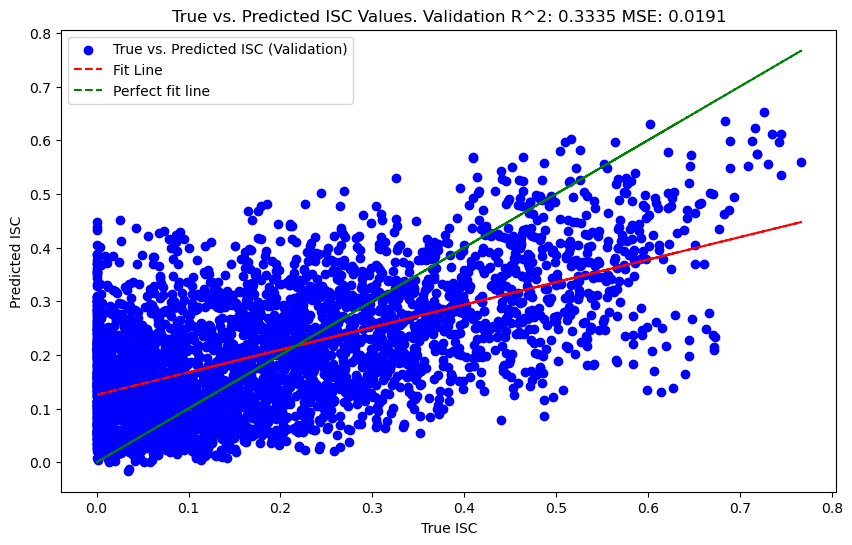

In [113]:

if os.path.exists(result_path):
    with open(result_path, 'rb') as handle:
        results = pickle.load(handle)
if  reTrainModels or not os.path.exists(model_weights_path):
    # retrain only if weights dont exist or we want to retrain
    # retrain model
    results['epoch_train_losses'], results['epoch_val_losses'], results['best_val_loss'] = train_model(train_loader, val_loader, model, criterion, optimizer, device, num_epochs=n_epochs, model_weights_path = model_weights_path)

        
if reComputeResults or not os.path.exists(result_path) or reTrainModels:
    # recompute results only if we want to recompute, or results dont exist, or we retrained models
    # load model weights and results
    model.load_state_dict(torch.load(model_weights_path, map_location=device))
    # recompute results
    model.eval()
    print('computing predictions and metrics for training set...')# Compute for training set
    results['y_train'], results['yest_train'], results['MSE_train'], results['R2_train'] = compute_predictions_and_metrics(train_loader,model, device)
    print('computing predictions and metrics for validation set...')# Compute for validation set
    results['y_val'], results['yest_val'], results['MSE_val'], results['R2_val'] = compute_predictions_and_metrics(val_loader,model, device)
    print('computing predictions and metrics for test set...')# Compute for test set 
    results['y_test'], results['yest_test'], results['MSE_test'], results['R2_test'] = compute_predictions_and_metrics(test_loader,model, device)
    print('computing predictions and metrics for test set (trainsubs)...')# Compute for test set (trainsubs)
    results['y_test_trainsubs'], results['yest_test_trainsubs'], results['MSE_test_trainsubs'], results['R2_test_trainsubs'], = compute_predictions_and_metrics(test_trainsubs_loader,model, device)
    # save results
    with open(result_path, 'wb') as handle:
        pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL) 

if os.path.exists(result_path) and os.path.exists(model_weights_path) and not reComputeResults and not reTrainModels:
    # if we didnt recompute anything and results exist, load them
    # load model
    model.load_state_dict(torch.load(model_weights_path, map_location=device))
    #load results
    with open(result_path, 'rb') as handle:
        results = pickle.load(handle)

# Plot the epoch losses
plot_epoch_losses(results)
# display the results
fig = display_results(results,'val')
# save the latest plot to a file
fig.savefig(validation_print_path)

#### COMPLEX CNN + LSTM

In [114]:
from model_definitions_ISC import ComplexCNNLSTMModel
input_channels = 1   
seq_length = 40    
hidden_size = 256  # Hidden size for the LSTM layer
num_layers = 2  # Number of LSTM layers
output_size = 1  # Output size
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the model
model = ComplexCNNLSTMModel(input_channels, seq_length, hidden_size, num_layers, output_size, normalize_features= True).to(device)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001,weight_decay=1e-5)
print(model)

ComplexCNNLSTMModel(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (dropout_cnn): Dropout(p=0.25, inplace=False)
  (lstm): LSTM(2048, 256, num_layers=2, batch_first=True)
  (dropout_lstm): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=256, out_features=64, bias=Tru

In [115]:
modelName = 'ComplexCNNLSTM'
model_params_str = f"_inchannels{input_channels}_seqlength{seq_length}_hidden{hidden_size}_layers{num_layers}_output{output_size}_nepochs_{n_epochs}_bsize_{batch_size}"
result_path = os.path.join(result_directory, modelName + model_params_str + '.pickle')
model_weights_path = os.path.join(result_directory, modelName + model_params_str + '_model_weights.pth')
validation_print_path = os.path.join(result_directory, 'val_results_' + modelName + model_params_str + '.png')
model_structure_path = os.path.join(result_directory, modelName + model_params_str + '.txt')
with open(model_structure_path, 'w') as f:
    print(model, file=f)
print(result_path)
print(model_weights_path)
print(validation_print_path)

../../results/python/1s_step_selectedpars/ComplexCNNLSTM_inchannels1_seqlength40_hidden256_layers2_output1_nepochs_110_bsize_128.pickle
../../results/python/1s_step_selectedpars/ComplexCNNLSTM_inchannels1_seqlength40_hidden256_layers2_output1_nepochs_110_bsize_128_model_weights.pth
../../results/python/1s_step_selectedpars/val_results_ComplexCNNLSTM_inchannels1_seqlength40_hidden256_layers2_output1_nepochs_110_bsize_128.png


Train R^2: 0.9719
Validation R^2: 0.4118


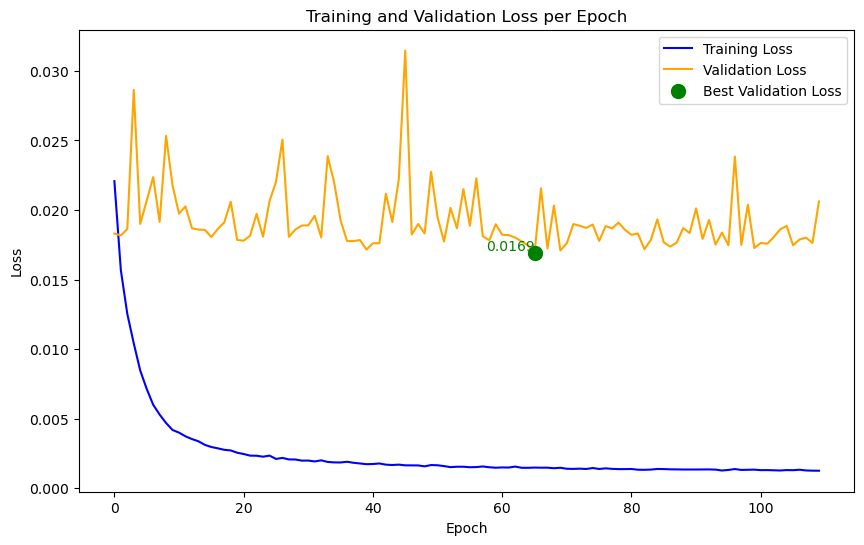

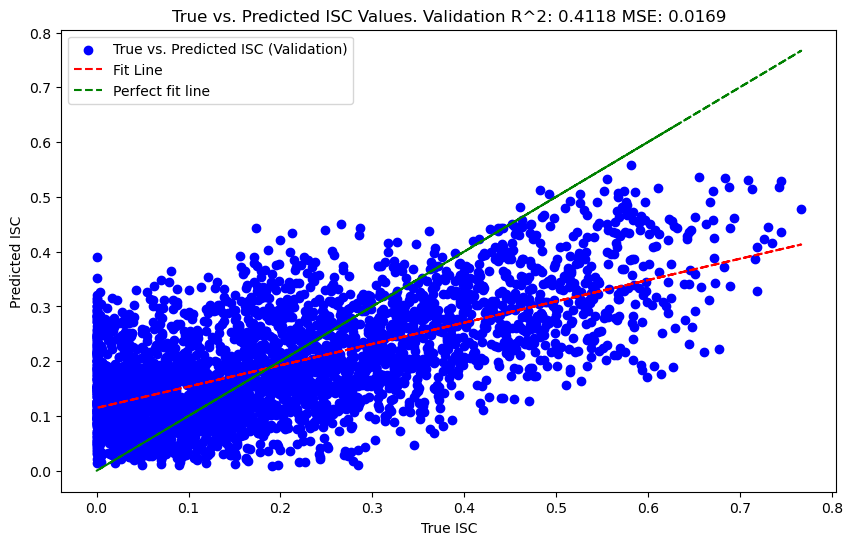

In [116]:

if os.path.exists(result_path):
    with open(result_path, 'rb') as handle:
        results = pickle.load(handle)
if  reTrainModels or not os.path.exists(model_weights_path):
    # retrain only if weights dont exist or we want to retrain
    # retrain model
    results['epoch_train_losses'], results['epoch_val_losses'], results['best_val_loss'] = train_model(train_loader, val_loader, model, criterion, optimizer, device, num_epochs=n_epochs, model_weights_path = model_weights_path)

if reComputeResults or not os.path.exists(result_path) or reTrainModels:
    # recompute results only if we want to recompute, or results dont exist, or we retrained models
    # load model weights and results
    model.load_state_dict(torch.load(model_weights_path, map_location=device))
    # recompute results
    model.eval()
    print('computing predictions and metrics for training set...')# Compute for training set
    results['y_train'], results['yest_train'], results['MSE_train'], results['R2_train'] = compute_predictions_and_metrics(train_loader,model, device)
    print('computing predictions and metrics for validation set...')# Compute for validation set
    results['y_val'], results['yest_val'], results['MSE_val'], results['R2_val'] = compute_predictions_and_metrics(val_loader,model, device)
    print('computing predictions and metrics for test set...')# Compute for test set 
    results['y_test'], results['yest_test'], results['MSE_test'], results['R2_test'] = compute_predictions_and_metrics(test_loader,model, device)
    print('computing predictions and metrics for test set (trainsubs)...')# Compute for test set (trainsubs)
    results['y_test_trainsubs'], results['yest_test_trainsubs'], results['MSE_test_trainsubs'], results['R2_test_trainsubs'], = compute_predictions_and_metrics(test_trainsubs_loader,model, device)
    # save results
    with open(result_path, 'wb') as handle:
        pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL) 

if os.path.exists(result_path) and os.path.exists(model_weights_path) and not reComputeResults and not reTrainModels:
    # if we didnt recompute anything and results exist, load them
    # load model
    model.load_state_dict(torch.load(model_weights_path, map_location=device))
    #load results
    with open(result_path, 'rb') as handle:
        results = pickle.load(handle)

# Plot the epoch losses
plot_epoch_losses(results)
# display the results
fig = display_results(results,'val')
# save the latest plot to a file
fig.savefig(validation_print_path)

#### Complex CNN + BiDirectional LSTM

In [117]:

from model_definitions_ISC import ComplexCNNBiDirLSTMModel
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_channels = 1   
seq_length = 40    
hidden_size = 256  # Hidden size for the LSTM layer
num_layers = 2  # Number of LSTM layers
output_size = 1  # Output size
# Initialize the model
model = ComplexCNNBiDirLSTMModel(input_channels = input_channels, seq_length = seq_length, hidden_size = hidden_size, num_layers = num_layers, output_size = output_size, normalize_features=True).to(device)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001,weight_decay=1e-5)
print(model)

ComplexCNNBiDirLSTMModel(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (dropout_cnn): Dropout(p=0.25, inplace=False)
  (lstm): LSTM(2048, 256, num_layers=2, batch_first=True, dropout=0.25, bidirectional=True)
  (dropout_lstm): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_

In [118]:
modelName = 'ComplexCNNBiDirLSTMModel'
model_params_str = f"_inchannels{input_channels}_seqlength{seq_length}_hidden{hidden_size}_layers{num_layers}_output{output_size}_nepochs_{n_epochs}_bsize_{batch_size}"
result_path = os.path.join(result_directory, modelName + model_params_str + '.pickle')
model_weights_path = os.path.join(result_directory, modelName + model_params_str + '_model_weights.pth')
validation_print_path = os.path.join(result_directory, 'val_results_' + modelName + model_params_str + '.png')
model_structure_path = os.path.join(result_directory, modelName + model_params_str + '.txt')
with open(model_structure_path, 'w') as f:
    print(model, file=f)
print(result_path)
print(model_weights_path)
print(validation_print_path)

../../results/python/1s_step_selectedpars/ComplexCNNBiDirLSTMModel_inchannels1_seqlength40_hidden256_layers2_output1_nepochs_110_bsize_128.pickle
../../results/python/1s_step_selectedpars/ComplexCNNBiDirLSTMModel_inchannels1_seqlength40_hidden256_layers2_output1_nepochs_110_bsize_128_model_weights.pth
../../results/python/1s_step_selectedpars/val_results_ComplexCNNBiDirLSTMModel_inchannels1_seqlength40_hidden256_layers2_output1_nepochs_110_bsize_128.png


Train R^2: 0.7271
Validation R^2: 0.3484


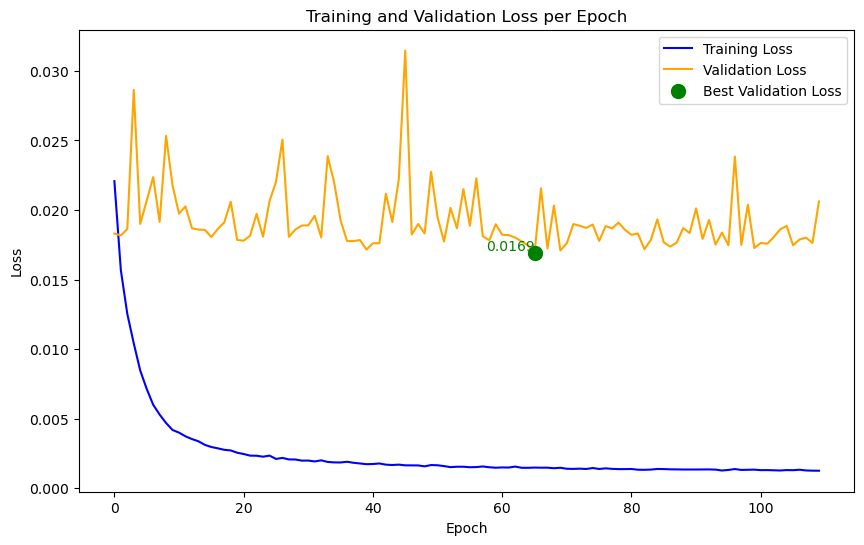

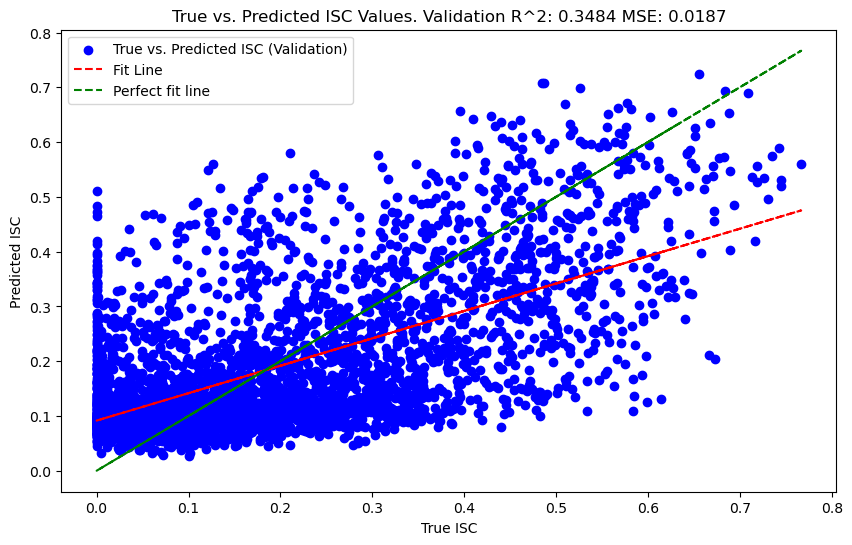

In [119]:
if os.path.exists(result_path):
    with open(result_path, 'rb') as handle:
        results = pickle.load(handle)
if  reTrainModels or not os.path.exists(model_weights_path):
    # retrain only if weights dont exist or we want to retrain
    # retrain model
    results['epoch_train_losses'], results['epoch_val_losses'], results['best_val_loss'] = train_model(train_loader, val_loader, model, criterion, optimizer, device, num_epochs=n_epochs, model_weights_path = model_weights_path)

if reComputeResults or not os.path.exists(result_path) or reTrainModels:
    # recompute results only if we want to recompute, or results dont exist, or we retrained models
    # load model weights and results
    model.load_state_dict(torch.load(model_weights_path, map_location=device))
    # recompute results
    model.eval()
    print('computing predictions and metrics for training set...')# Compute for training set
    results['y_train'], results['yest_train'], results['MSE_train'], results['R2_train'] = compute_predictions_and_metrics(train_loader,model, device)
    print('computing predictions and metrics for validation set...')# Compute for validation set
    results['y_val'], results['yest_val'], results['MSE_val'], results['R2_val'] = compute_predictions_and_metrics(val_loader,model, device)
    print('computing predictions and metrics for test set...')# Compute for test set 
    results['y_test'], results['yest_test'], results['MSE_test'], results['R2_test'] = compute_predictions_and_metrics(test_loader,model, device)
    print('computing predictions and metrics for test set (trainsubs)...')# Compute for test set (trainsubs)
    results['y_test_trainsubs'], results['yest_test_trainsubs'], results['MSE_test_trainsubs'], results['R2_test_trainsubs'], = compute_predictions_and_metrics(test_trainsubs_loader,model, device)
    # save results
    with open(result_path, 'wb') as handle:
        pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL) 

if os.path.exists(result_path) and os.path.exists(model_weights_path) and not reComputeResults and not reTrainModels:
    # if we didnt recompute anything and results exist, load them
    # load model
    model.load_state_dict(torch.load(model_weights_path, map_location=device))
    #load results
    with open(result_path, 'rb') as handle:
        results = pickle.load(handle)

# Plot the epoch losses
plot_epoch_losses(results)
# display the results
fig = display_results(results,'val')
# save the latest plot to a file
fig.savefig(validation_print_path)

#### Residual CNN + LSTM

In [120]:

from model_definitions_ISC import ResidualCNNLSTMModel
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_channels = 1   
seq_length = 40    
hidden_size = 256  # Hidden size for the LSTM layer
num_layers = 2  # Number of LSTM layers
output_size = 1  # Output size
# Initialize the model
model = ResidualCNNLSTMModel(input_channels = input_channels, seq_length = seq_length, hidden_size = hidden_size, num_layers = num_layers, output_size = output_size, normalize_features=True).to(device)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001,weight_decay=1e-5)
print(model)


ResidualCNNLSTMModel(
  (residual_block1): ResidualBlock(
    (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (shortcut): Sequential(
      (0): Conv2d(1, 64, kernel_size=(1, 1), stride=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (residual_block2): ResidualBlock(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [121]:
modelName = 'ResidualCNNLSTMModel'
model_params_str = f"_inchannels{input_channels}_seqlength{seq_length}_hidden{hidden_size}_layers{num_layers}_output{output_size}_nepochs_{n_epochs}_bsize_{batch_size}"
result_path = os.path.join(result_directory, modelName + model_params_str + '.pickle')
model_weights_path = os.path.join(result_directory, modelName + model_params_str + '_model_weights.pth')
validation_print_path = os.path.join(result_directory, 'val_results_' + modelName + model_params_str + '.png')
model_structure_path = os.path.join(result_directory, modelName + model_params_str + '.txt')
with open(model_structure_path, 'w') as f:
    print(model, file=f)
print(result_path)
print(model_weights_path)
print(validation_print_path)

../../results/python/1s_step_selectedpars/ResidualCNNLSTMModel_inchannels1_seqlength40_hidden256_layers2_output1_nepochs_110_bsize_128.pickle
../../results/python/1s_step_selectedpars/ResidualCNNLSTMModel_inchannels1_seqlength40_hidden256_layers2_output1_nepochs_110_bsize_128_model_weights.pth
../../results/python/1s_step_selectedpars/val_results_ResidualCNNLSTMModel_inchannels1_seqlength40_hidden256_layers2_output1_nepochs_110_bsize_128.png


Train R^2: 0.9690
Validation R^2: 0.3978


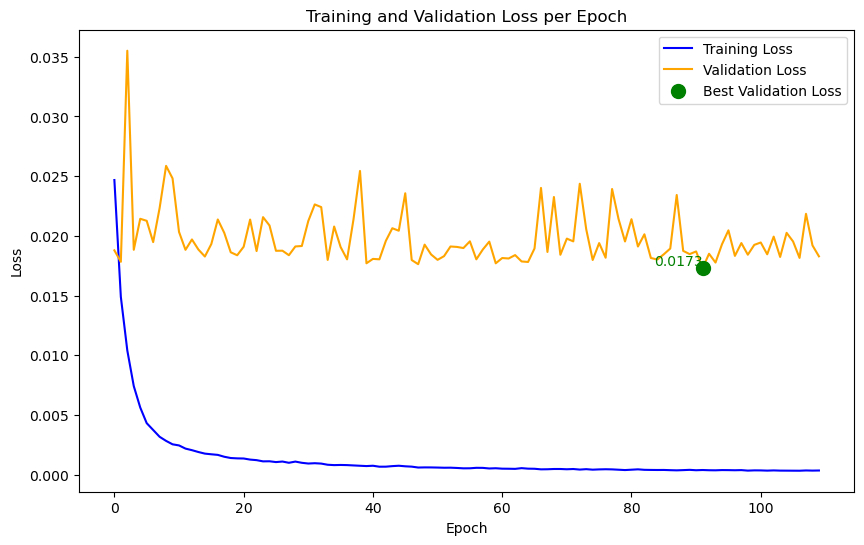

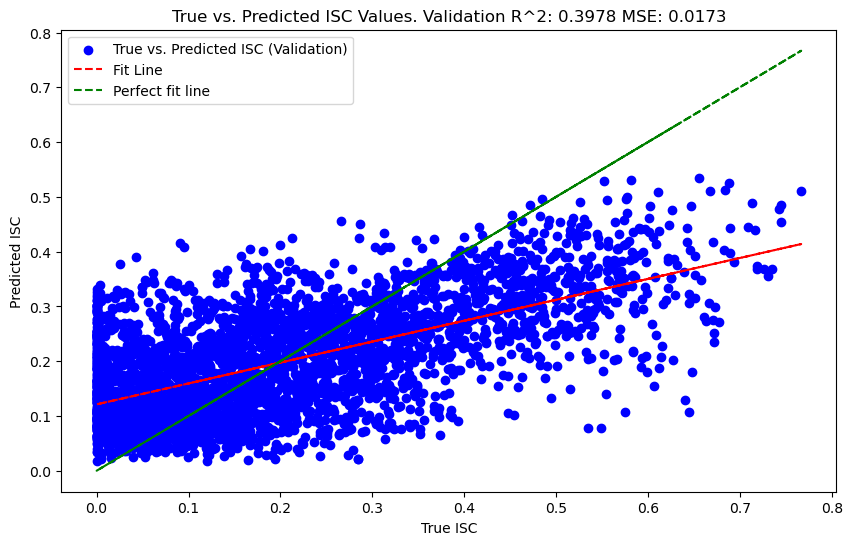

In [122]:
if os.path.exists(result_path):
    with open(result_path, 'rb') as handle:
        results = pickle.load(handle)
if  reTrainModels or not os.path.exists(model_weights_path):
    # retrain only if weights dont exist or we want to retrain
    # retrain model
    results['epoch_train_losses'], results['epoch_val_losses'], results['best_val_loss'] = train_model(train_loader, val_loader, model, criterion, optimizer, device, num_epochs=n_epochs, model_weights_path = model_weights_path)

if reComputeResults or not os.path.exists(result_path) or reTrainModels:
    # recompute results only if we want to recompute, or results dont exist, or we retrained models
    # load model weights and results
    model.load_state_dict(torch.load(model_weights_path, map_location=device))
    # recompute results
    model.eval()
    print('computing predictions and metrics for training set...')# Compute for training set
    results['y_train'], results['yest_train'], results['MSE_train'], results['R2_train'] = compute_predictions_and_metrics(train_loader,model, device)
    print('computing predictions and metrics for validation set...')# Compute for validation set
    results['y_val'], results['yest_val'], results['MSE_val'], results['R2_val'] = compute_predictions_and_metrics(val_loader,model, device)
    print('computing predictions and metrics for test set...')# Compute for test set 
    results['y_test'], results['yest_test'], results['MSE_test'], results['R2_test'] = compute_predictions_and_metrics(test_loader,model, device)
    print('computing predictions and metrics for test set (trainsubs)...')# Compute for test set (trainsubs)
    results['y_test_trainsubs'], results['yest_test_trainsubs'], results['MSE_test_trainsubs'], results['R2_test_trainsubs'], = compute_predictions_and_metrics(test_trainsubs_loader,model, device)
    # save results
    with open(result_path, 'wb') as handle:
        pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL) 

if os.path.exists(result_path) and os.path.exists(model_weights_path) and not reComputeResults and not reTrainModels:
    # if we didnt recompute anything and results exist, load them
    # load model
    model.load_state_dict(torch.load(model_weights_path, map_location=device))
    #load results
    with open(result_path, 'rb') as handle:
        results = pickle.load(handle)

# Plot the epoch losses
plot_epoch_losses(results)
# display the results
fig = display_results(results,'val')
# save the latest plot to a file
fig.savefig(validation_print_path)

#### ResNET


In [123]:
from model_definitions_ISC import ResNet
input_channels = 64   
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_shape = (input_channels, 40)  # Input shape of the data
nb_classes = 1
# Initialize the model
model = ResNet(input_shape = input_shape, nb_classes = nb_classes, normalize_features=True).to(device)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001,weight_decay=1e-5)
print(model)

ResNet(
  (block1): ResNetBlock(
    (conv0): Conv1d(64, 32, kernel_size=(21,), stride=(1,), padding=(10,))
    (bn0): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv1): Conv1d(32, 32, kernel_size=(9,), stride=(1,), padding=(4,))
    (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv1d(32, 32, kernel_size=(5,), stride=(1,), padding=(2,))
    (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (bn3): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (shortcut): Sequential(
      (0): Conv1d(64, 32, kernel_size=(1,), stride=(1,))
      (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (block2): ResNetBlock(
    (conv0): Conv1d(32, 64, kernel_size=(21,), stride=(1,), padding

In [124]:
modelName = 'ResNet'
model_params_str = f"_inchannels{input_channels}_output{nb_classes}_nepochs_{n_epochs}_bsize_{batch_size}"
result_path = os.path.join(result_directory, modelName + model_params_str + '.pickle')
model_weights_path = os.path.join(result_directory, modelName + model_params_str + '_model_weights.pth')
validation_print_path = os.path.join(result_directory, 'val_results_' + modelName + model_params_str + '.png')
model_structure_path = os.path.join(result_directory, modelName + model_params_str + '.txt')
with open(model_structure_path, 'w') as f:
    print(model, file=f)
print(result_path)
print(model_weights_path)
print(validation_print_path)

../../results/python/1s_step_selectedpars/ResNet_inchannels64_output1_nepochs_110_bsize_128.pickle
../../results/python/1s_step_selectedpars/ResNet_inchannels64_output1_nepochs_110_bsize_128_model_weights.pth
../../results/python/1s_step_selectedpars/val_results_ResNet_inchannels64_output1_nepochs_110_bsize_128.png


Train R^2: 0.9632
Validation R^2: 0.3065


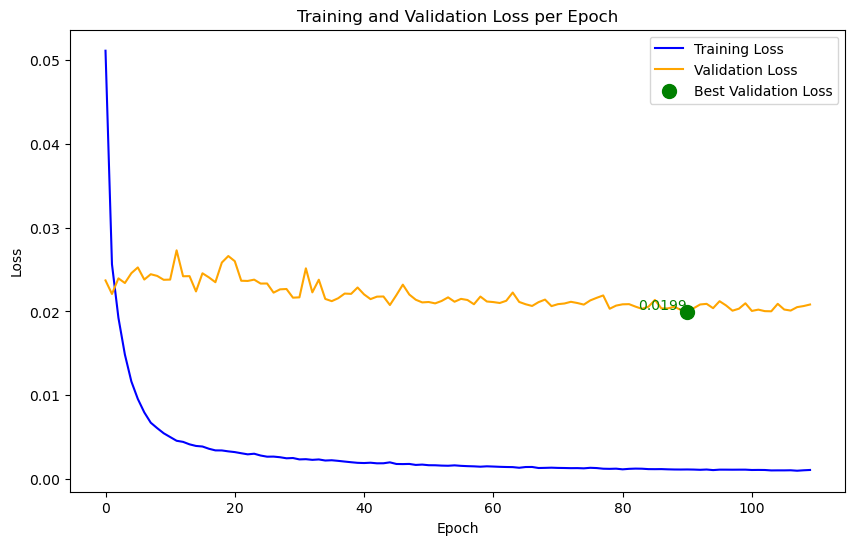

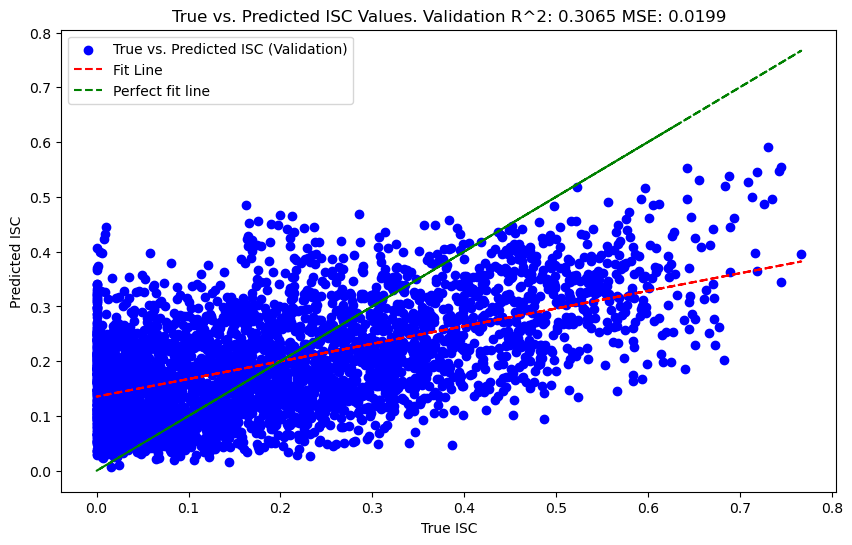

In [125]:

if os.path.exists(result_path):
    with open(result_path, 'rb') as handle:
        results = pickle.load(handle)
if  reTrainModels or not os.path.exists(model_weights_path):
    # retrain only if weights dont exist or we want to retrain
    # retrain model
    results['epoch_train_losses'], results['epoch_val_losses'], results['best_val_loss'] = train_model(train_loader, val_loader, model, criterion, optimizer, device, num_epochs=n_epochs, model_weights_path = model_weights_path)

    
if reComputeResults or not os.path.exists(result_path) or reTrainModels:
    # recompute results only if we want to recompute, or results dont exist, or we retrained models
    # load model weights and results
    model.load_state_dict(torch.load(model_weights_path, map_location=device))
    # recompute results
    model.eval()
    print('computing predictions and metrics for training set...')# Compute for training set
    results['y_train'], results['yest_train'], results['MSE_train'], results['R2_train'] = compute_predictions_and_metrics(train_loader,model, device)
    print('computing predictions and metrics for validation set...')# Compute for validation set
    results['y_val'], results['yest_val'], results['MSE_val'], results['R2_val'] = compute_predictions_and_metrics(val_loader,model, device)
    print('computing predictions and metrics for test set...')# Compute for test set 
    results['y_test'], results['yest_test'], results['MSE_test'], results['R2_test'] = compute_predictions_and_metrics(test_loader,model, device)
    print('computing predictions and metrics for test set (trainsubs)...')# Compute for test set (trainsubs)
    results['y_test_trainsubs'], results['yest_test_trainsubs'], results['MSE_test_trainsubs'], results['R2_test_trainsubs'], = compute_predictions_and_metrics(test_trainsubs_loader,model, device)
    # save results
    with open(result_path, 'wb') as handle:
        pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL) 

if os.path.exists(result_path) and os.path.exists(model_weights_path) and not reComputeResults and not reTrainModels:
    # if we didnt recompute anything and results exist, load them
    # load model
    model.load_state_dict(torch.load(model_weights_path, map_location=device))
    #load results
    with open(result_path, 'rb') as handle:
        results = pickle.load(handle)

# Plot the epoch losses
plot_epoch_losses(results)
# display the results
fig = display_results(results,'val')
# save the latest plot to a file
fig.savefig(validation_print_path)

#### ResNet + LSTM

In [126]:
from model_definitions_ISC import ResNet_LSTM


input_channels = 64   
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_shape = (input_channels, 40)  # Input shape of the data
nb_classes = 1
# Initialize the model
model = ResNet_LSTM(input_shape = input_shape, nb_classes = nb_classes, normalize_features=True).to(device)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = 0.0001,weight_decay=1e-5)
print(model)


ResNet_LSTM(
  (block1): ResNetBlock(
    (conv0): Conv1d(64, 64, kernel_size=(21,), stride=(1,), padding=(10,))
    (bn0): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv1): Conv1d(64, 64, kernel_size=(9,), stride=(1,), padding=(4,))
    (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv1d(64, 64, kernel_size=(5,), stride=(1,), padding=(2,))
    (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (shortcut): Sequential(
      (0): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (block2): ResNetBlock(
    (conv0): Conv1d(64, 128, kernel_size=(21,), stride=(1,), p

In [127]:
modelName = 'ResNet_LSTM'
model_params_str = f"_inchannels{input_channels}_output{nb_classes}_nepochs_{n_epochs}_bsize_{batch_size}"
result_path = os.path.join(result_directory, modelName + model_params_str + '.pickle')
model_weights_path = os.path.join(result_directory, modelName + model_params_str + '_model_weights.pth')
validation_print_path = os.path.join(result_directory, 'val_results_' + modelName + model_params_str + '.png')
model_structure_path = os.path.join(result_directory, modelName + model_params_str + '.txt')
with open(model_structure_path, 'w') as f:
    print(model, file=f)
print(result_path)
print(model_weights_path)
print(validation_print_path)

../../results/python/1s_step_selectedpars/ResNet_LSTM_inchannels64_output1_nepochs_110_bsize_128.pickle
../../results/python/1s_step_selectedpars/ResNet_LSTM_inchannels64_output1_nepochs_110_bsize_128_model_weights.pth
../../results/python/1s_step_selectedpars/val_results_ResNet_LSTM_inchannels64_output1_nepochs_110_bsize_128.png


Train R^2: 0.9697
Validation R^2: 0.3245


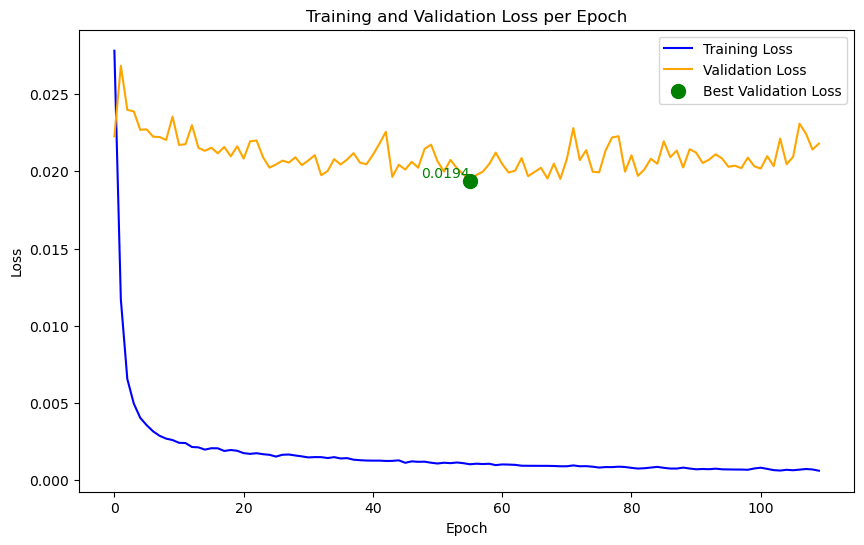

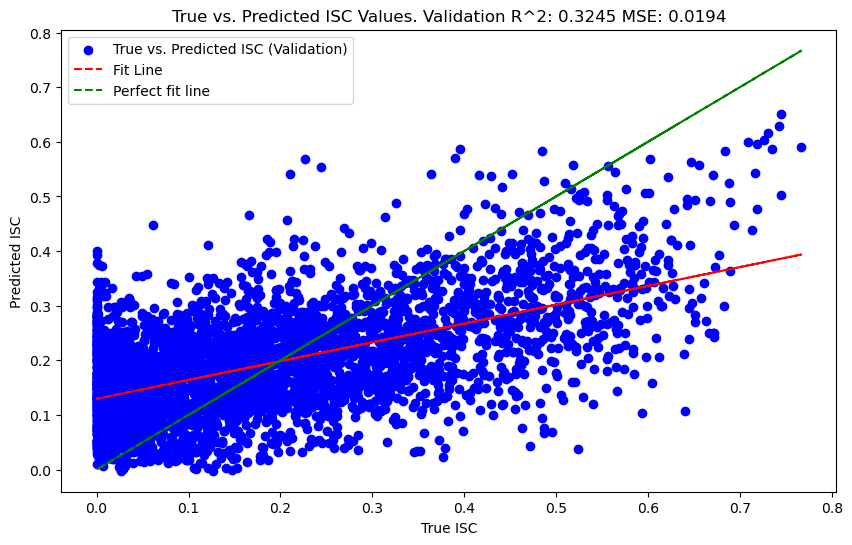

In [128]:

if os.path.exists(result_path):
    with open(result_path, 'rb') as handle:
        results = pickle.load(handle)
if  reTrainModels or not os.path.exists(model_weights_path):
    # retrain only if weights dont exist or we want to retrain
    # retrain model
    results['epoch_train_losses'], results['epoch_val_losses'], results['best_val_loss'] = train_model(train_loader, val_loader, model, criterion, optimizer, device, num_epochs=n_epochs, model_weights_path = model_weights_path)

        
if reComputeResults or not os.path.exists(result_path) or reTrainModels:
    # recompute results only if we want to recompute, or results dont exist, or we retrained models
    # load model weights and results
    model.load_state_dict(torch.load(model_weights_path, map_location=device))
    # recompute results
    model.eval()
    print('computing predictions and metrics for training set...')# Compute for training set
    results['y_train'], results['yest_train'], results['MSE_train'], results['R2_train'] = compute_predictions_and_metrics(train_loader,model, device)
    print('computing predictions and metrics for validation set...')# Compute for validation set
    results['y_val'], results['yest_val'], results['MSE_val'], results['R2_val'] = compute_predictions_and_metrics(val_loader,model, device)
    print('computing predictions and metrics for test set...')# Compute for test set 
    results['y_test'], results['yest_test'], results['MSE_test'], results['R2_test'] = compute_predictions_and_metrics(test_loader,model, device)
    print('computing predictions and metrics for test set (trainsubs)...')# Compute for test set (trainsubs)
    results['y_test_trainsubs'], results['yest_test_trainsubs'], results['MSE_test_trainsubs'], results['R2_test_trainsubs'], = compute_predictions_and_metrics(test_trainsubs_loader,model, device)
    # save results
    with open(result_path, 'wb') as handle:
        pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL) 

if os.path.exists(result_path) and os.path.exists(model_weights_path) and not reComputeResults and not reTrainModels:
    # if we didnt recompute anything and results exist, load them
    # load model
    model.load_state_dict(torch.load(model_weights_path, map_location=device))
    #load results
    with open(result_path, 'rb') as handle:
        results = pickle.load(handle)

# Plot the epoch losses
plot_epoch_losses(results)
# display the results
fig = display_results(results,'val')
# save the latest plot to a file
fig.savefig(validation_print_path)

#### ResNet2D


In [129]:
from model_definitions_ISC import ResNet2D


input_channels = 64   
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_shape = (input_channels, 40)  # Input shape of the data
nb_classes = 1
# Initialize the model
model = ResNet2D(input_shape = input_shape, nb_classes = nb_classes, normalize_features=True).to(device)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = 0.0001,weight_decay=1e-5)
print(model)

summary(model, input_size = (input_channels, 40))

ResNet2D(
  (block1): ResNetBlock2D(
    (conv0): Conv2d(1, 64, kernel_size=(3, 21), stride=(1, 1), padding=same)
    (bn0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv1): Conv2d(64, 64, kernel_size=(3, 9), stride=(1, 1), padding=same)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 5), stride=(1, 1), padding=same)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (shortcut): Sequential(
      (0): Conv2d(1, 64, kernel_size=(1, 1), stride=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (block2): ResNetBlock2D(
    (conv0): Conv2d(64, 64, kernel_size=(3, 

In [130]:
modelName = 'ResNet2D'
model_params_str = f"_inchannels{input_channels}_output{nb_classes}_nepochs_{n_epochs}_bsize_{batch_size}"
result_path = os.path.join(result_directory, modelName + model_params_str + '.pickle')
model_weights_path = os.path.join(result_directory, modelName + model_params_str + '_model_weights.pth')
validation_print_path = os.path.join(result_directory, 'val_results_' + modelName + model_params_str + '.png')
model_structure_path = os.path.join(result_directory, modelName + model_params_str + '.txt')
with open(model_structure_path, 'w') as f:
    print(model, file=f)
print(result_path)
print(model_weights_path)
print(validation_print_path)

../../results/python/1s_step_selectedpars/ResNet2D_inchannels64_output1_nepochs_110_bsize_128.pickle
../../results/python/1s_step_selectedpars/ResNet2D_inchannels64_output1_nepochs_110_bsize_128_model_weights.pth
../../results/python/1s_step_selectedpars/val_results_ResNet2D_inchannels64_output1_nepochs_110_bsize_128.png


Train R^2: 0.9028
Validation R^2: 0.3527


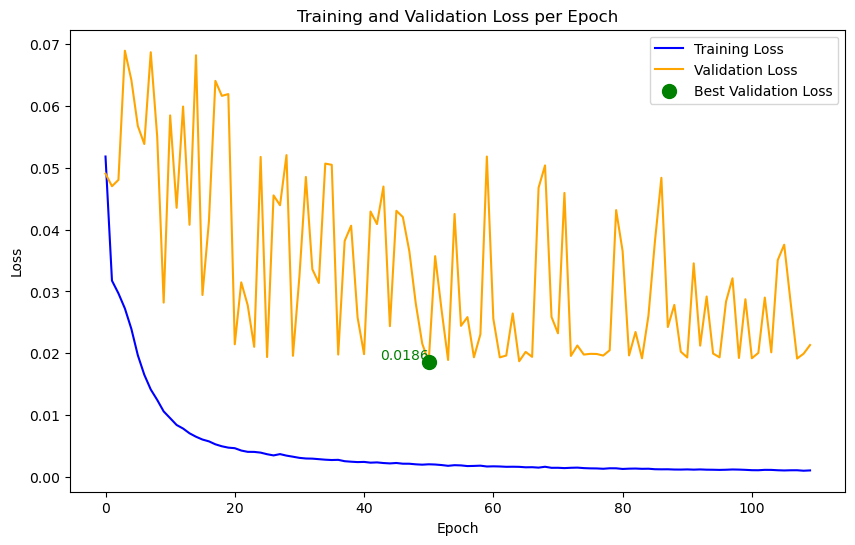

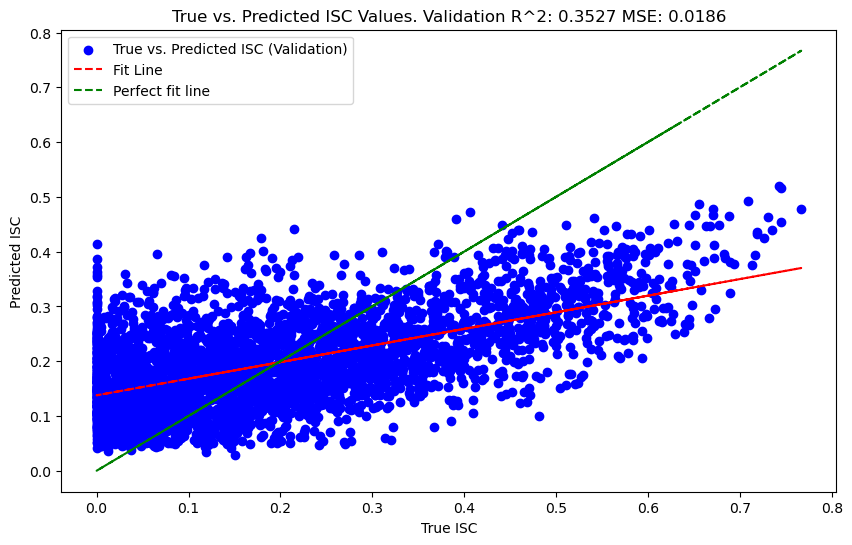

In [131]:

if os.path.exists(result_path):
    with open(result_path, 'rb') as handle:
        results = pickle.load(handle)
if  reTrainModels or not os.path.exists(model_weights_path):
    # retrain only if weights dont exist or we want to retrain
    # retrain model
    results['epoch_train_losses'], results['epoch_val_losses'], results['best_val_loss'] = train_model(train_loader, val_loader, model, criterion, optimizer, device, num_epochs=n_epochs, model_weights_path = model_weights_path)

        
if reComputeResults or not os.path.exists(result_path) or reTrainModels:
    # recompute results only if we want to recompute, or results dont exist, or we retrained models
    # load model weights and results
    model.load_state_dict(torch.load(model_weights_path, map_location=device))
    # recompute results
    model.eval()
    print('computing predictions and metrics for training set...')# Compute for training set
    results['y_train'], results['yest_train'], results['MSE_train'], results['R2_train'] = compute_predictions_and_metrics(train_loader,model, device)
    print('computing predictions and metrics for validation set...')# Compute for validation set
    results['y_val'], results['yest_val'], results['MSE_val'], results['R2_val'] = compute_predictions_and_metrics(val_loader,model, device)
    print('computing predictions and metrics for test set...')# Compute for test set 
    results['y_test'], results['yest_test'], results['MSE_test'], results['R2_test'] = compute_predictions_and_metrics(test_loader,model, device)
    print('computing predictions and metrics for test set (trainsubs)...')# Compute for test set (trainsubs)
    results['y_test_trainsubs'], results['yest_test_trainsubs'], results['MSE_test_trainsubs'], results['R2_test_trainsubs'], = compute_predictions_and_metrics(test_trainsubs_loader,model, device)
    # save results
    with open(result_path, 'wb') as handle:
        pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL) 

if os.path.exists(result_path) and os.path.exists(model_weights_path) and not reComputeResults and not reTrainModels:
    # if we didnt recompute anything and results exist, load them
    # load model
    # model.load_state_dict(torch.load(model_weights_path, map_location=device))
    #load results
    with open(result_path, 'rb') as handle:
        results = pickle.load(handle)

# Plot the epoch losses
plot_epoch_losses(results)
# display the results
fig = display_results(results,'val')
# save the latest plot to a file
fig.savefig(validation_print_path)

In [132]:
reTrainModels = False

#### FCN

In [133]:
from model_definitions_ISC import FCN
input_channels = 64   
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_shape = (input_channels, 40)  # Input shape of the data
nb_classes = 1
# Initialize the model
model = FCN(input_shape = input_shape, nb_classes = nb_classes, normalize_features=True).to(device)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001,weight_decay=1e-5)
print(model)
summary(model, (64, 40))

FCN(
  (conv1): Conv1d(64, 128, kernel_size=(9,), stride=(1,), padding=same)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1d(128, 256, kernel_size=(5,), stride=(1,), padding=same)
  (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv1d(256, 128, kernel_size=(3,), stride=(1,), padding=same)
  (bn3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gap): AdaptiveAvgPool1d(output_size=1)
  (fc1): Linear(in_features=128, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
  (drop): Dropout(p=0.25, inplace=False)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 128, 40]          73,856
       BatchNorm1d-2              [-1, 128, 40]             256
              ReLU-3        

In [134]:
modelName = 'FCN'
model_params_str = f"_inchannels{input_channels}_output{nb_classes}_nepochs_{n_epochs}_bsize_{batch_size}"
result_path = os.path.join(result_directory, modelName + model_params_str + '.pickle')
model_weights_path = os.path.join(result_directory, modelName + model_params_str + '_model_weights.pth')
validation_print_path = os.path.join(result_directory, 'val_results_' + modelName + model_params_str + '.png')
model_structure_path = os.path.join(result_directory, modelName + model_params_str + '.txt')
with open(model_structure_path, 'w') as f:
    print(model, file=f)
print(result_path)
print(model_weights_path)
print(validation_print_path)

../../results/python/1s_step_selectedpars/FCN_inchannels64_output1_nepochs_110_bsize_128.pickle
../../results/python/1s_step_selectedpars/FCN_inchannels64_output1_nepochs_110_bsize_128_model_weights.pth
../../results/python/1s_step_selectedpars/val_results_FCN_inchannels64_output1_nepochs_110_bsize_128.png


Train R^2: 0.5263
Validation R^2: 0.3331


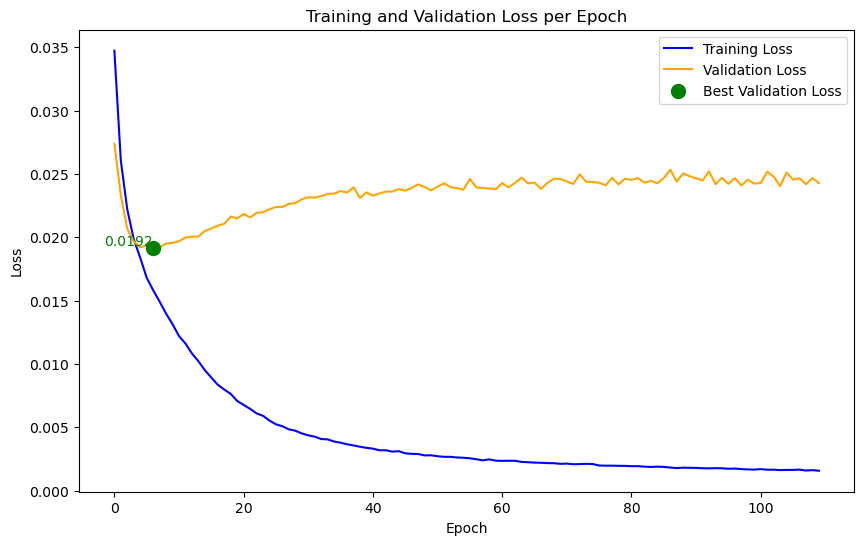

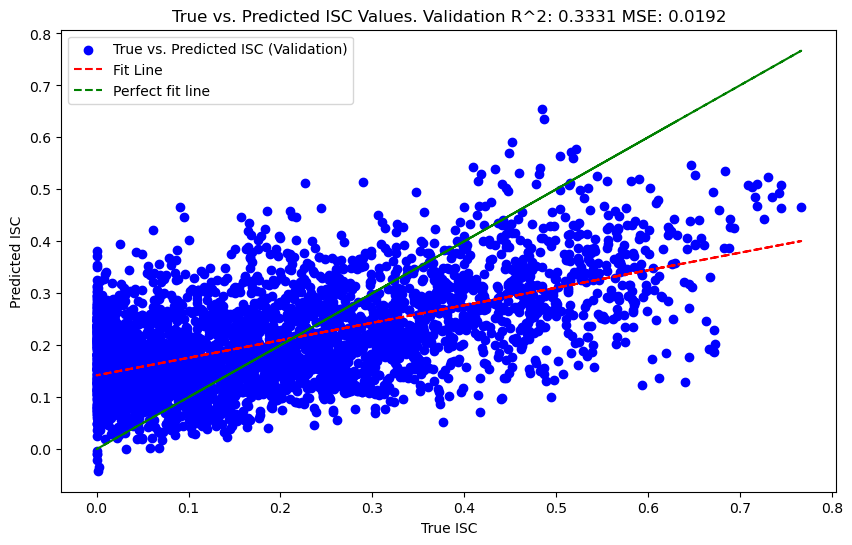

In [135]:

if os.path.exists(result_path):
    with open(result_path, 'rb') as handle:
        results = pickle.load(handle)
if  reTrainModels or not os.path.exists(model_weights_path):
    # retrain only if weights dont exist or we want to retrain
    # retrain model
    results['epoch_train_losses'], results['epoch_val_losses'], results['best_val_loss'] = train_model(train_loader, val_loader, model, criterion, optimizer, device, num_epochs=n_epochs, model_weights_path = model_weights_path)

if reComputeResults or not os.path.exists(result_path) or reTrainModels:
    # recompute results only if we want to recompute, or results dont exist, or we retrained models
    # load model weights and results
    model.load_state_dict(torch.load(model_weights_path, map_location=device))
    # recompute results
    model.eval()
    print('computing predictions and metrics for training set...')# Compute for training set
    results['y_train'], results['yest_train'], results['MSE_train'], results['R2_train'] = compute_predictions_and_metrics(train_loader,model, device)
    print('computing predictions and metrics for validation set...')# Compute for validation set
    results['y_val'], results['yest_val'], results['MSE_val'], results['R2_val'] = compute_predictions_and_metrics(val_loader,model, device)
    print('computing predictions and metrics for test set...')# Compute for test set 
    results['y_test'], results['yest_test'], results['MSE_test'], results['R2_test'] = compute_predictions_and_metrics(test_loader,model, device)
    print('computing predictions and metrics for test set (trainsubs)...')# Compute for test set (trainsubs)
    results['y_test_trainsubs'], results['yest_test_trainsubs'], results['MSE_test_trainsubs'], results['R2_test_trainsubs'], = compute_predictions_and_metrics(test_trainsubs_loader,model, device)
    # save results
    with open(result_path, 'wb') as handle:
        pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL) 

if os.path.exists(result_path) and os.path.exists(model_weights_path) and not reComputeResults and not reTrainModels:
    # if we didnt recompute anything and results exist, load them
    # load model
    model.load_state_dict(torch.load(model_weights_path, map_location=device))
    #load results
    with open(result_path, 'rb') as handle:
        results = pickle.load(handle)

# Plot the epoch losses
plot_epoch_losses(results)
# display the results
fig = display_results(results,'val')
# save the latest plot to a file
fig.savefig(validation_print_path)

#### ENCODER

In [136]:
from model_definitions_ISC import ENCODER
input_channels = 64   
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_shape = (input_channels, 40)  # Input shape of the data
nb_classes = 1
# Initialize the model
model = ENCODER(input_shape = input_shape, nb_classes = nb_classes, normalize_features=True).to(device)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001,weight_decay=1e-5)
print(model)

ENCODER(
  (conv1): Sequential(
    (0): Conv1d(64, 128, kernel_size=(5,), stride=(1,), padding=same)
    (1): InstanceNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): PReLU(num_parameters=1)
    (3): Dropout(p=0.2, inplace=False)
    (4): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv1d(128, 256, kernel_size=(11,), stride=(1,), padding=same)
    (1): InstanceNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): PReLU(num_parameters=1)
    (3): Dropout(p=0.2, inplace=False)
    (4): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv1d(256, 512, kernel_size=(21,), stride=(1,), padding=same)
    (1): InstanceNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): PReLU(num_parameters=1)
    (3): Dropout(p=0.2, inplace=False)
  )
  (attention_softmax): Soft

In [137]:
modelName = 'ENCODER'
model_params_str = f"_inchannels{input_channels}_output{nb_classes}_nepochs_{n_epochs}_bsize_{batch_size}"
result_path = os.path.join(result_directory, modelName + model_params_str + '.pickle')
model_weights_path = os.path.join(result_directory, modelName + model_params_str + '_model_weights.pth')
validation_print_path = os.path.join(result_directory, 'val_results_' + modelName + model_params_str + '.png')
model_structure_path = os.path.join(result_directory, modelName + model_params_str + '.txt')
with open(model_structure_path, 'w') as f:
    print(model, file=f)
print(result_path)
print(model_weights_path)
print(validation_print_path)

../../results/python/1s_step_selectedpars/ENCODER_inchannels64_output1_nepochs_110_bsize_128.pickle
../../results/python/1s_step_selectedpars/ENCODER_inchannels64_output1_nepochs_110_bsize_128_model_weights.pth
../../results/python/1s_step_selectedpars/val_results_ENCODER_inchannels64_output1_nepochs_110_bsize_128.png


Train R^2: 0.9610
Validation R^2: 0.3659


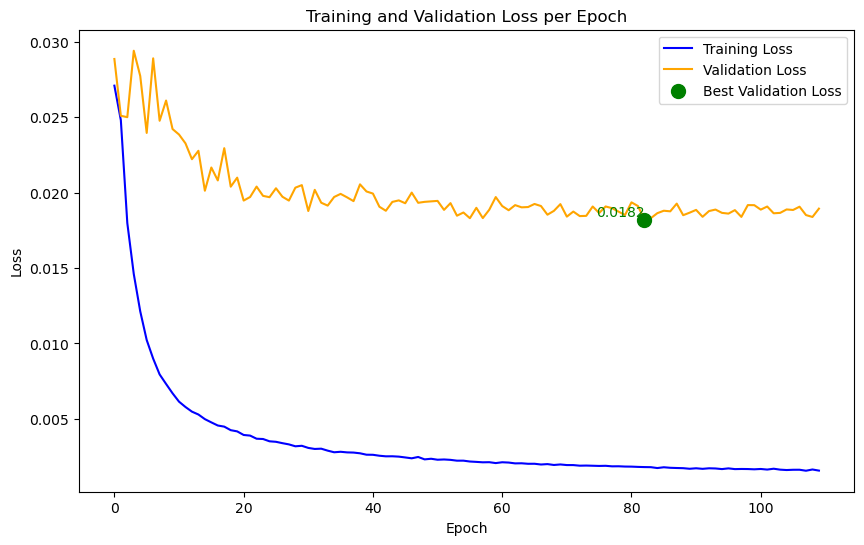

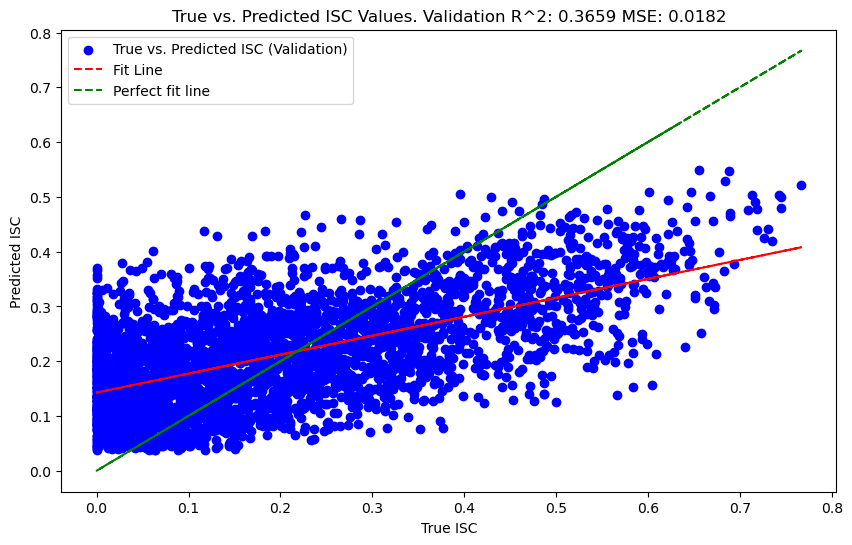

In [138]:

if os.path.exists(result_path):
    with open(result_path, 'rb') as handle:
        results = pickle.load(handle)
if  reTrainModels or not os.path.exists(model_weights_path):
    # retrain only if weights dont exist or we want to retrain
    # retrain model
    results['epoch_train_losses'], results['epoch_val_losses'], results['best_val_loss'] = train_model(train_loader, val_loader, model, criterion, optimizer, device, num_epochs=n_epochs, model_weights_path = model_weights_path)
        
if reComputeResults or not os.path.exists(result_path) or reTrainModels:
    # recompute results only if we want to recompute, or results dont exist, or we retrained models
    # load model weights and results
    model.load_state_dict(torch.load(model_weights_path, map_location=device))
    # recompute results
    model.eval()
    print('computing predictions and metrics for training set...')# Compute for training set
    results['y_train'], results['yest_train'], results['MSE_train'], results['R2_train'] = compute_predictions_and_metrics(train_loader,model, device)
    print('computing predictions and metrics for validation set...')# Compute for validation set
    results['y_val'], results['yest_val'], results['MSE_val'], results['R2_val'] = compute_predictions_and_metrics(val_loader,model, device)
    print('computing predictions and metrics for test set...')# Compute for test set 
    results['y_test'], results['yest_test'], results['MSE_test'], results['R2_test'] = compute_predictions_and_metrics(test_loader,model, device)
    print('computing predictions and metrics for test set (trainsubs)...')# Compute for test set (trainsubs)
    results['y_test_trainsubs'], results['yest_test_trainsubs'], results['MSE_test_trainsubs'], results['R2_test_trainsubs'], = compute_predictions_and_metrics(test_trainsubs_loader,model, device)
    # save results
    with open(result_path, 'wb') as handle:
        pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL) 

if os.path.exists(result_path) and os.path.exists(model_weights_path) and not reComputeResults and not reTrainModels:
    # if we didnt recompute anything and results exist, load them
    # load model
    model.load_state_dict(torch.load(model_weights_path, map_location=device))
    #load results
    with open(result_path, 'rb') as handle:
        results = pickle.load(handle)

# Plot the epoch losses
plot_epoch_losses(results)
# display the results
fig = display_results(results,'val')
# save the latest plot to a file

fig.savefig(validation_print_path)

#### Time-LeNet

In [139]:
from model_definitions_ISC import TimeLeNet
input_channels = 64   
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_shape = (input_channels, 40)  # Input shape of the data
nb_classes = 1
# Initialize the model
model = TimeLeNet(input_shape = input_shape, nb_classes = nb_classes, normalize_features=True).to(device)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001,weight_decay=1e-5)
# optimizer = optim.Adam(model.parameters(), lr=0.2,weight_decay=1e-5)

print(model)

TimeLeNet(
  (conv1): Conv1d(64, 5, kernel_size=(5,), stride=(1,), padding=same)
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(5, 20, kernel_size=(5,), stride=(1,), padding=same)
  (pool2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (bn1): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=100, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=1, bias=True)
  (relu): ReLU()
  (drop): Dropout(p=0.25, inplace=False)
)


In [140]:
modelName = 'TimeLeNet'
model_params_str = f"_inchannels{input_channels}_output{nb_classes}_nepochs_{n_epochs}_bsize_{batch_size}"
result_path = os.path.join(result_directory, modelName + model_params_str + '.pickle')
model_weights_path = os.path.join(result_directory, modelName + model_params_str + '_model_weights.pth')
validation_print_path = os.path.join(result_directory, 'val_results_' + modelName + model_params_str + '.png')
model_structure_path = os.path.join(result_directory, modelName + model_params_str + '.txt')
with open(model_structure_path, 'w') as f:
    print(model, file=f)
print(result_path)
print(model_weights_path)
print(validation_print_path)

../../results/python/1s_step_selectedpars/TimeLeNet_inchannels64_output1_nepochs_110_bsize_128.pickle
../../results/python/1s_step_selectedpars/TimeLeNet_inchannels64_output1_nepochs_110_bsize_128_model_weights.pth
../../results/python/1s_step_selectedpars/val_results_TimeLeNet_inchannels64_output1_nepochs_110_bsize_128.png


Train R^2: 0.3155
Validation R^2: 0.3300


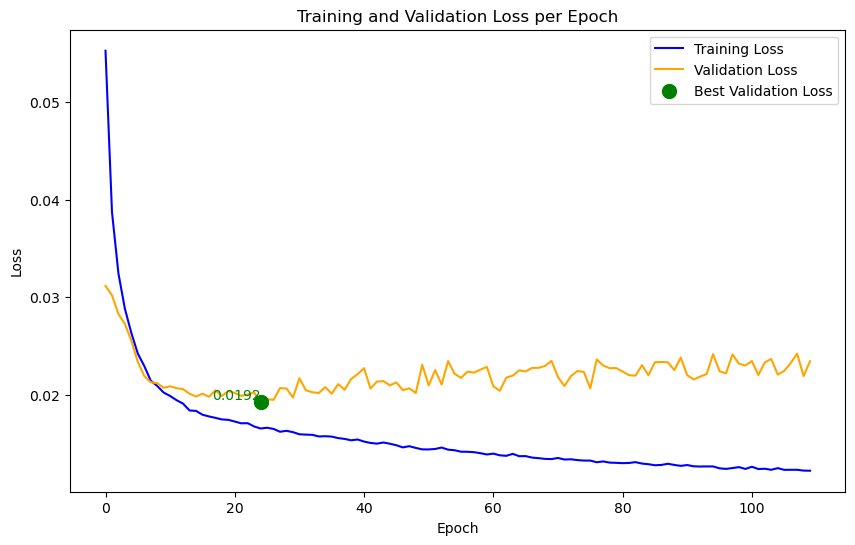

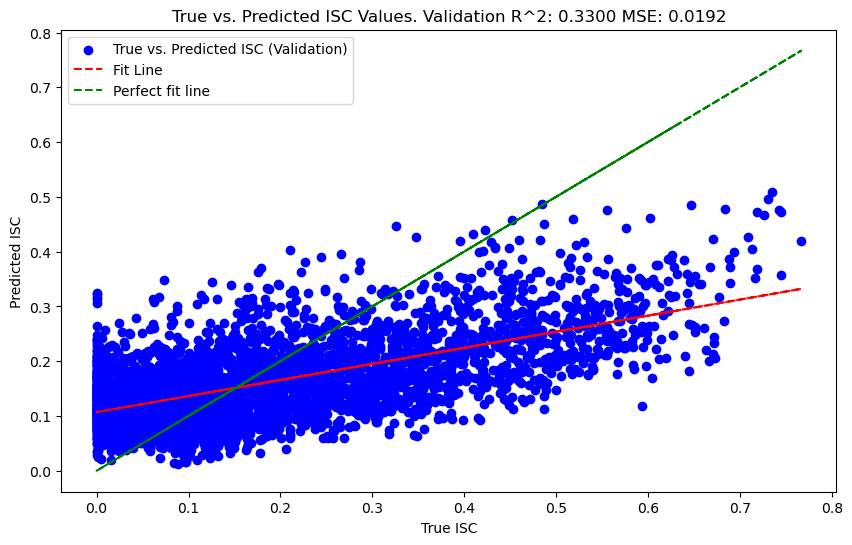

In [141]:
if os.path.exists(result_path):
    with open(result_path, 'rb') as handle:
        results = pickle.load(handle)
if  reTrainModels or not os.path.exists(model_weights_path):
    # retrain only if weights dont exist or we want to retrain
    # retrain model
    results['epoch_train_losses'], results['epoch_val_losses'], results['best_val_loss'] = train_model(train_loader, val_loader, model, criterion, optimizer, device, num_epochs=n_epochs, model_weights_path = model_weights_path)
            
if reComputeResults or not os.path.exists(result_path) or reTrainModels:
    # recompute results only if we want to recompute, or results dont exist, or we retrained models
    # load model weights and results
    model.load_state_dict(torch.load(model_weights_path, map_location=device))
    # recompute results
    model.eval()
    print('computing predictions and metrics for training set...')# Compute for training set
    results['y_train'], results['yest_train'], results['MSE_train'], results['R2_train'] = compute_predictions_and_metrics(train_loader,model, device)
    print('computing predictions and metrics for validation set...')# Compute for validation set
    results['y_val'], results['yest_val'], results['MSE_val'], results['R2_val'] = compute_predictions_and_metrics(val_loader,model, device)
    print('computing predictions and metrics for test set...')# Compute for test set 
    results['y_test'], results['yest_test'], results['MSE_test'], results['R2_test'] = compute_predictions_and_metrics(test_loader,model, device)
    print('computing predictions and metrics for test set (trainsubs)...')# Compute for test set (trainsubs)
    results['y_test_trainsubs'], results['yest_test_trainsubs'], results['MSE_test_trainsubs'], results['R2_test_trainsubs'], = compute_predictions_and_metrics(test_trainsubs_loader,model, device)
    # save results
    with open(result_path, 'wb') as handle:
        pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL) 

if os.path.exists(result_path) and os.path.exists(model_weights_path) and not reComputeResults and not reTrainModels:
    # if we didnt recompute anything and results exist, load them
    # load model
    model.load_state_dict(torch.load(model_weights_path, map_location=device))
    #load results
    with open(result_path, 'rb') as handle:
        results = pickle.load(handle)

# Plot the epoch losses
plot_epoch_losses(results)
# display the results
fig = display_results(results,'val')
# save the latest plot to a file
fig.savefig(validation_print_path)

#### MCDCNN (Multi-Channel Deep Convolutional Neural Network)

In [142]:
from model_definitions_ISC import MCDCNN
input_channels = 64   
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_shape = (input_channels, 40)  # Input shape of the data
nb_classes = 1
# Initialize the model
model = MCDCNN(input_shape = input_shape, nb_classes = nb_classes, normalize_features=True).to(device)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001, weight_decay=1e-5)
print(model)
summary(model, (64, 40))

MCDCNN(
  (conv1_layers): ModuleList(
    (0-63): 64 x Sequential(
      (0): Conv1d(1, 8, kernel_size=(5,), stride=(1,), padding=same)
      (1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (conv2_layers): ModuleList(
    (0-63): 64 x Sequential(
      (0): Conv1d(8, 8, kernel_size=(5,), stride=(1,), padding=same)
      (1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): AdaptiveAvgPool1d(output_size=2)
      (4): Flatten(start_dim=1, end_dim=-1)
    )
  )
  (fc1): Linear(in_features=1024, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
  (drop): Dropout(p=0.25, inplace=False)
)
----------------------------------------------------------------
        Layer (t

In [143]:
modelName = 'MCDCNN'
model_params_str = f"_inchannels{input_channels}_output{nb_classes}_nepochs_{n_epochs}_bsize_{batch_size}"
result_path = os.path.join(result_directory, modelName + model_params_str + '.pickle')
model_weights_path = os.path.join(result_directory, modelName + model_params_str + '_model_weights.pth')
validation_print_path = os.path.join(result_directory, 'val_results_' + modelName + model_params_str + '.png')
model_structure_path = os.path.join(result_directory, modelName + model_params_str + '.txt')
with open(model_structure_path, 'w') as f:
    print(model, file=f)
print(result_path)
print(model_weights_path)
print(validation_print_path)

../../results/python/1s_step_selectedpars/MCDCNN_inchannels64_output1_nepochs_110_bsize_128.pickle
../../results/python/1s_step_selectedpars/MCDCNN_inchannels64_output1_nepochs_110_bsize_128_model_weights.pth
../../results/python/1s_step_selectedpars/val_results_MCDCNN_inchannels64_output1_nepochs_110_bsize_128.png


Train R^2: 0.4299
Validation R^2: 0.3530


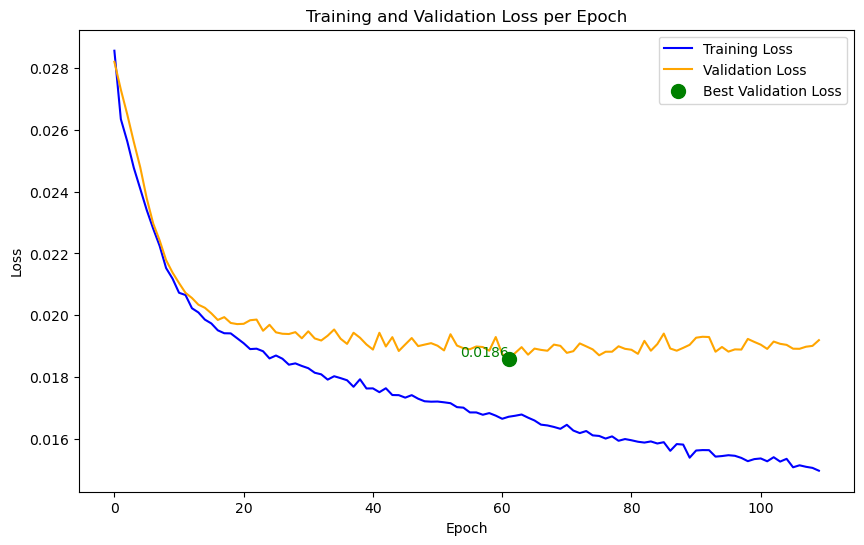

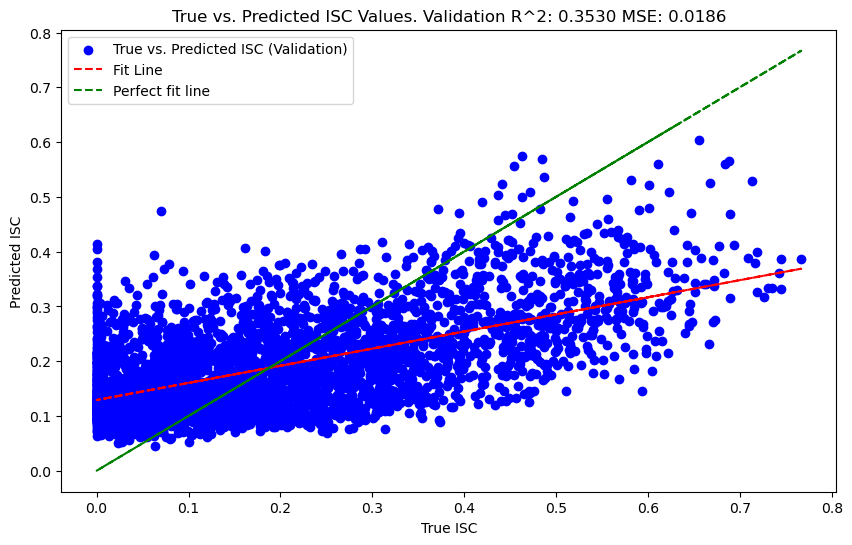

In [144]:
if os.path.exists(result_path):
    with open(result_path, 'rb') as handle:
        results = pickle.load(handle)
if  reTrainModels or not os.path.exists(model_weights_path):
    # retrain only if weights dont exist or we want to retrain
    # retrain model
    results['epoch_train_losses'], results['epoch_val_losses'], results['best_val_loss'] = train_model(train_loader, val_loader, model, criterion, optimizer, device, num_epochs=n_epochs, model_weights_path = model_weights_path)
        
if reComputeResults or not os.path.exists(result_path) or reTrainModels:
    # recompute results only if we want to recompute, or results dont exist, or we retrained models
    # load model weights and results
    model.load_state_dict(torch.load(model_weights_path, map_location=device))
    # recompute results
    model.eval()
    print('computing predictions and metrics for training set...')# Compute for training set
    results['y_train'], results['yest_train'], results['MSE_train'], results['R2_train'] = compute_predictions_and_metrics(train_loader,model, device)
    print('computing predictions and metrics for validation set...')# Compute for validation set
    results['y_val'], results['yest_val'], results['MSE_val'], results['R2_val'] = compute_predictions_and_metrics(val_loader,model, device)
    print('computing predictions and metrics for test set...')# Compute for test set 
    results['y_test'], results['yest_test'], results['MSE_test'], results['R2_test'] = compute_predictions_and_metrics(test_loader,model, device)
    print('computing predictions and metrics for test set (trainsubs)...')# Compute for test set (trainsubs)
    results['y_test_trainsubs'], results['yest_test_trainsubs'], results['MSE_test_trainsubs'], results['R2_test_trainsubs'], = compute_predictions_and_metrics(test_trainsubs_loader,model, device)
    # save results
    with open(result_path, 'wb') as handle:
        pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL) 

if os.path.exists(result_path) and os.path.exists(model_weights_path) and not reComputeResults and not reTrainModels:
    # if we didnt recompute anything and results exist, load them
    # load model
    model.load_state_dict(torch.load(model_weights_path, map_location=device))
    #load results
    with open(result_path, 'rb') as handle:
        results = pickle.load(handle)

# Plot the epoch losses
plot_epoch_losses(results)
# display the results
fig = display_results(results,'val')
# save the latest plot to a file
fig.savefig(validation_print_path)

#### LSFAN
https://arxiv.org/abs/2406.16913


In [145]:
from model_definitions_ISC import LSFAN
input_channels = 64   
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_shape = (input_channels, 40)  # Input shape of the data
nb_classes = 1
# Initialize the model
model = LSFAN(input_shape = input_shape, nb_classes = nb_classes, normalize_features=True).to(device)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001,weight_decay=1e-5)
print(model)
summary(model, (64, 40))

LSFAN(
  (conv1): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool1): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(4, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool2): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
  (tap): AdaptiveAvgPool2d(output_size=(None, 1))
  (attention): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=16, out_features=16, bias=True)
  )
  (fc1): Linear(in_features=1024, out_features=480, bias=True)
  (fc2): Linear(in_features=480, out_features=1, bias=True)
  (relu): ReLU()
  (drop): Dropout(p=0.25, inplace=False)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 4, 64, 40]              40
              ReLU-2            [-1, 4, 64, 40]               0
           Dropout-3            [

In [146]:
modelName = 'LSFAN'
model_params_str = f"_inchannels{input_channels}_output{nb_classes}_nepochs_{n_epochs}_bsize_{batch_size}"
result_path = os.path.join(result_directory, modelName + model_params_str + '.pickle')
model_weights_path = os.path.join(result_directory, modelName + model_params_str + '_model_weights.pth')
validation_print_path = os.path.join(result_directory, 'val_results_' + modelName + model_params_str + '.png')
model_structure_path = os.path.join(result_directory, modelName + model_params_str + '.txt')
with open(model_structure_path, 'w') as f:
    print(model, file=f)
print(result_path)
print(model_weights_path)
print(validation_print_path)

../../results/python/1s_step_selectedpars/LSFAN_inchannels64_output1_nepochs_110_bsize_128.pickle
../../results/python/1s_step_selectedpars/LSFAN_inchannels64_output1_nepochs_110_bsize_128_model_weights.pth
../../results/python/1s_step_selectedpars/val_results_LSFAN_inchannels64_output1_nepochs_110_bsize_128.png


Train R^2: -0.0904
Validation R^2: -0.0334


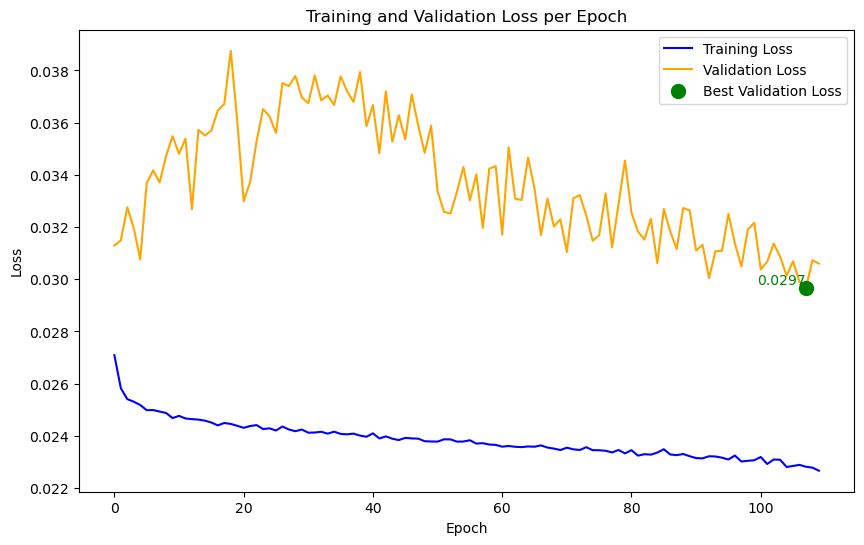

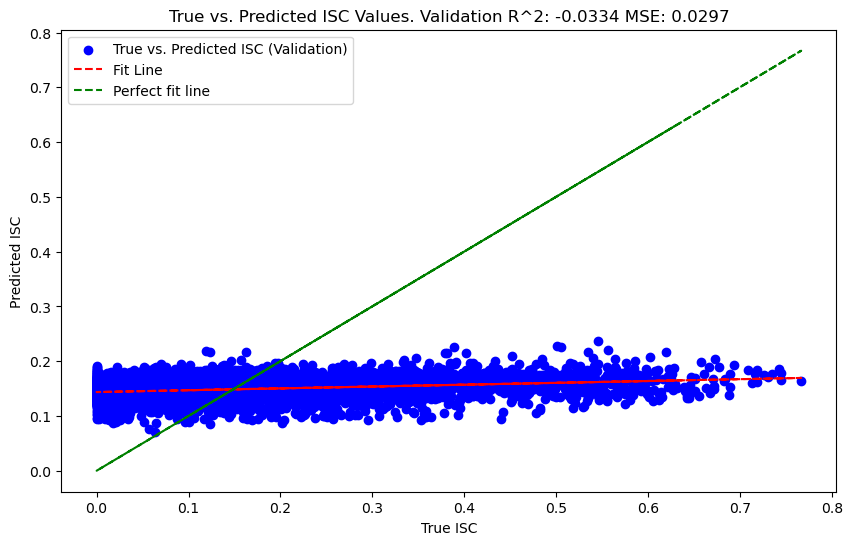

In [147]:
if os.path.exists(result_path):
    with open(result_path, 'rb') as handle:
        results = pickle.load(handle)
if  reTrainModels or not os.path.exists(model_weights_path):
    # retrain only if weights dont exist or we want to retrain
    # retrain model
    results['epoch_train_losses'], results['epoch_val_losses'], results['best_val_loss'] = train_model(train_loader, val_loader, model, criterion, optimizer, device, num_epochs=n_epochs, model_weights_path = model_weights_path)
        
if reComputeResults or not os.path.exists(result_path) or reTrainModels:
    # recompute results only if we want to recompute, or results dont exist, or we retrained models
    # load model weights and results
    model.load_state_dict(torch.load(model_weights_path, map_location=device))
    # recompute results
    model.eval()
    print('computing predictions and metrics for training set...')# Compute for training set
    results['y_train'], results['yest_train'], results['MSE_train'], results['R2_train'] = compute_predictions_and_metrics(train_loader,model, device)
    print('computing predictions and metrics for validation set...')# Compute for validation set
    results['y_val'], results['yest_val'], results['MSE_val'], results['R2_val'] = compute_predictions_and_metrics(val_loader,model, device)
    print('computing predictions and metrics for test set...')# Compute for test set 
    results['y_test'], results['yest_test'], results['MSE_test'], results['R2_test'] = compute_predictions_and_metrics(test_loader,model, device)
    print('computing predictions and metrics for test set (trainsubs)...')# Compute for test set (trainsubs)
    results['y_test_trainsubs'], results['yest_test_trainsubs'], results['MSE_test_trainsubs'], results['R2_test_trainsubs'], = compute_predictions_and_metrics(test_trainsubs_loader,model, device)
    # save results
    with open(result_path, 'wb') as handle:
        pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL) 

if os.path.exists(result_path) and os.path.exists(model_weights_path) and not reComputeResults and not reTrainModels:
    # if we didnt recompute anything and results exist, load them
    # load model
    model.load_state_dict(torch.load(model_weights_path, map_location=device))
    #load results
    with open(result_path, 'rb') as handle:
        results = pickle.load(handle)

# Plot the epoch losses
plot_epoch_losses(results)
# display the results
fig = display_results(results,'val')
# save the latest plot to a file
fig.savefig(validation_print_path)

----------------------------

### Results on the best performing model, chosen by validation error (2D CNN + LSTM)

Train R^2: 0.9719
Validation R^2: 0.4118
Test R^2: 0.3621
Test (train subjects) R^2: 0.4627


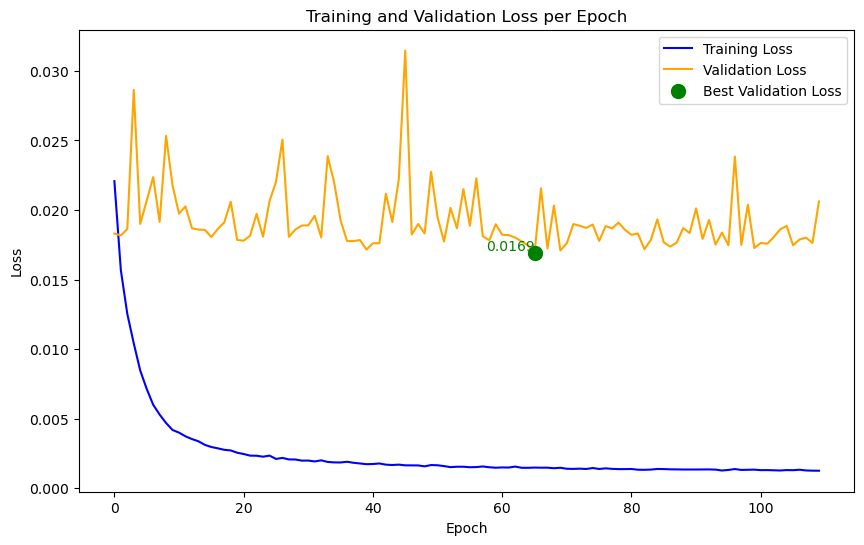

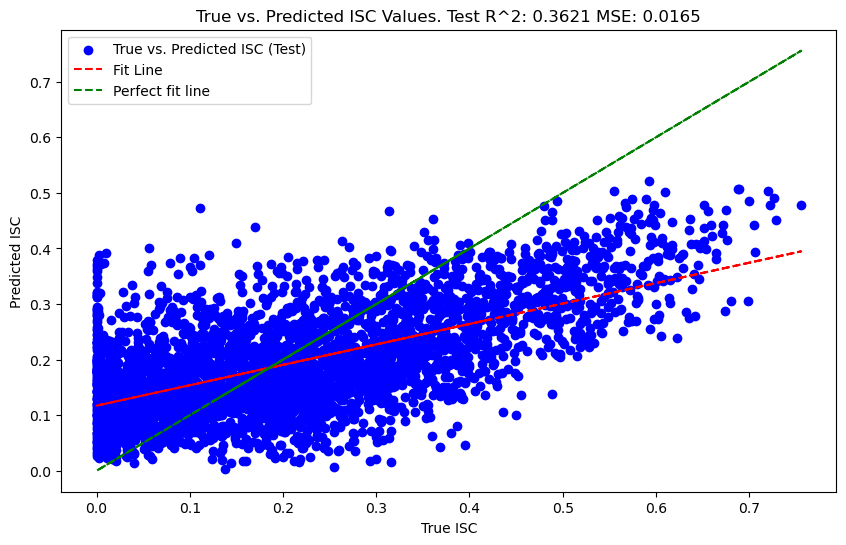

In [73]:
from model_definitions_ISC import ComplexCNNLSTMModel
input_channels = 1   
seq_length = 40    
hidden_size = 256  # Hidden size for the LSTM layer
num_layers = 2  # Number of LSTM layers
output_size = 1  # Output size
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the model
model = ComplexCNNLSTMModel(input_channels, seq_length, hidden_size, num_layers, output_size, normalize_features= True).to(device)
modelName = 'ComplexCNNLSTM'
model_params_str = f"_inchannels{input_channels}_seqlength{seq_length}_hidden{hidden_size}_layers{num_layers}_output{output_size}_nepochs_{n_epochs}_bsize_{batch_size}"
result_path = os.path.join(result_directory, modelName + model_params_str + '.pickle')
model_weights_path = os.path.join(result_directory, modelName + model_params_str + '_model_weights.pth')
validation_print_path = os.path.join(result_directory, 'val_results_' + modelName + model_params_str + '.png')
model_structure_path = os.path.join(result_directory, modelName + model_params_str + '.txt')

if os.path.exists(result_path) and os.path.exists(model_weights_path):
    # if we didnt recompute anything and results exist, load them
    # load model
    model.load_state_dict(torch.load(model_weights_path, map_location=device))
    #load results
    with open(result_path, 'rb') as handle:
        results = pickle.load(handle)

# Plot the epoch losses
plot_epoch_losses(results)
# display the results
fig = display_results(results,'test')

In [74]:
reComputeResults = False

In [ ]:
from dataset_utils import create_dataloader_ISC_alldata
from model_definitions_ISC import evaluate_model
import matplotlib.pyplot as plt    
alldata_loader = create_dataloader_ISC_alldata(metadata, data_path, batch_size=1000, num_workers=0,shuffle=False, pin_memory=False, transform=None)
y_true, y_pred, mse, r2 = evaluate_model(alldata_loader, model, device)
print(mse)
print(r2)

plt.scatter(metadata['target_ISC'], y_pred)
plt.xlabel('target_ISC')
plt.ylabel('predicted_ISC')
plt.title('Scatter plot of y_true against target_ISC')
plt.show()

metadata['predictions'] = y_pred
metadata.to_csv(os.path.join(result_directory,'metadata_with_predictions_selectedpars.csv'), index=False)


### Feature ablation study

On the pretrained model, we 0-out the features and check the performance of each.

In [ ]:

from dataset_utils import create_dataloader_ISC_alldata_ablation
ablations = ['blendshapes', 'rotation', 'brow', 'cheek', 'eye','jaw', 'mouth','nose' ]

# iterate over ablations
for ablation in ablations:
    metadata[ablation] = 0
    alldata_loader_ablation = create_dataloader_ISC_alldata_ablation(metadata, data_path, batch_size=1000, num_workers=4,shuffle=False, pin_memory=False, transform=None, ablation = ablation)
    
    # Evaluate the model with the ablated feature
    y_true, y_pred, mse, r2 = evaluate_model(alldata_loader_ablation, model, device)
    
    # Print the results
    print(f"Ablation: {ablation}")
    print(f"MSE: {mse}")
    print(f"R2: {r2}")
    metadata['predictions_ablation_'+ablation] = y_pred
    
    # metadata.to_csv('metadata_with_predictions_ablations.csv', index=False)
    metadata.to_csv(os.path.join(result_directory,'metadata_with_predictions_ablations.csv'), index=False)


### Test on unseen Data: MULTIMODAL (same stims)

In [77]:
metadata_path = '../../processed/timeISC/metadata_ISC_fs=4Hz_urs_1_windowsz=40_stepsz=4_multimodal.csv'
metadata_multimodal = pd.read_csv(metadata_path)    
alldata_loader_multimodal = create_dataloader_ISC_alldata(metadata_multimodal, data_path, batch_size=1000, num_workers=0,shuffle=False, pin_memory=False)
y_true, y_pred, mse, r2 = evaluate_model(alldata_loader_multimodal, model, device)
print(mse)
print(r2)
metadata_multimodal['predictions'] = y_pred
metadata_multimodal.to_csv(os.path.join(result_directory,'metadata_with_predictions_multimodal.csv'), index=False)

0.023812918
0.15674165112185345


#### Test ablation on unseen Data: MULTIMODAL (same stims)

In [78]:
from dataset_utils import create_dataloader_ISC_alldata_ablation
ablations = ['blendshapes', 'rotation', 'brow', 'cheek', 'eye','jaw', 'mouth','nose' ]

# iterate over ablations
for ablation in ablations:
    metadata_multimodal[ablation] = 0
    alldata_loader_ablation = create_dataloader_ISC_alldata_ablation(metadata_multimodal, data_path, batch_size=1000, num_workers=4,shuffle=False, pin_memory=False, transform=None, ablation = ablation)
    
    # Evaluate the model with the ablated feature
    y_true, y_pred, mse, r2 = evaluate_model(alldata_loader_ablation, model, device)
    
    # Print the results
    print(f"Ablation: {ablation}")
    print(f"MSE: {mse}")
    print(f"R2: {r2}")
    metadata_multimodal['predictions_ablation_'+ablation] = y_pred
    
    
        
    # metadata.to_csv('metadata_with_predictions_ablations.csv', index=False)
    metadata_multimodal.to_csv(os.path.join(result_directory,'metadata_with_predictions_multimodal_ablations.csv'), index=False)

Ablation: blendshapes
MSE: 0.03899484872817993
R2: -0.38087773664102387
Ablation: rotation
MSE: 0.023695169016718864
R2: 0.1609113898927167
Ablation: brow
MSE: 0.02558002434670925
R2: 0.09416539062148721
Ablation: cheek
MSE: 0.023054836317896843
R2: 0.1835867591413919
Ablation: eye
MSE: 0.03533341363072395
R2: -0.2512196638583557
Ablation: jaw
MSE: 0.023845314979553223
R2: 0.15559458661140635
Ablation: mouth
MSE: 0.023933861404657364
R2: 0.15245889664624268
Ablation: nose
MSE: 0.023956134915351868
R2: 0.15167007926946263


### Test on unseen Data: MULTISTYLE (different stims)

In [ ]:
metadata_path = '../../processed/timeISC/metadata_ISC_fs=4Hz_urs_1_windowsz=40_stepsz=4_multistyle.csv'
metadata_multistyle = pd.read_csv(metadata_path)    
alldata_loader_multistyle = create_dataloader_ISC_alldata(metadata_multistyle, data_path, batch_size=1000, num_workers=4,shuffle=False, pin_memory=False)
y_true, y_pred, mse, r2 = evaluate_model(alldata_loader_multistyle, model, device)
print(mse)
print(r2)
metadata_multistyle['predictions'] = y_pred
metadata_multistyle.to_csv(os.path.join(result_directory,'metadata_with_predictions_multistyle.csv'), index=False)
# from scipy.stats import pearsonr
# correlation, _ = pearsonr(metadata_multistyle['target_ISC'], metadata_multistyle['predictions'])
# print(f"Correlation: {correlation}")

#### Test ablation on unseen Data: MULTISTYLE (different stims)

In [ ]:
ablations = ['blendshapes', 'rotation', 'brow', 'cheek', 'eye','jaw', 'mouth','nose' ]

# iterate over ablations
for ablation in ablations:
    metadata_multistyle[ablation] = 0
    alldata_loader_ablation = create_dataloader_ISC_alldata_ablation(metadata_multistyle, data_path, batch_size=1000, num_workers=4,shuffle=False, pin_memory=False, transform=None, ablation = ablation)
    
    # Evaluate the model with the ablated feature
    y_true, y_pred, mse, r2 = evaluate_model(alldata_loader_ablation, model, device)
    
    # Print the results
    print(f"Ablation: {ablation}")
    print(f"MSE: {mse}")
    print(f"R2: {r2}")
    metadata_multistyle['predictions_ablation_'+ablation] = y_pred
    
    # metadata.to_csv('metadata_with_predictions_ablations.csv', index=False)
    metadata_multistyle.to_csv(os.path.join(result_directory,'metadata_with_predictions_multistyle_ablations.csv'), index=False)